### Notebook for generating embeddings from triplet judgements from GPT3 and Humans

#### Lisa Padua, Siddarth Suresh, Kushin Mukherjee, Tim Rogers

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding

/home/siddsuresh97/packages/anaconda3/envs/salmon/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Concrete Concepts

In [ ]:
conda activate salmon

## GPT3 triplets

### Summer - 

In [142]:
##load in GPT triplets

trips_df_1 = pd.read_csv('../../results/reptile_tool/davinci_triplet_feature_list_pruned.csv', index_col=0).reset_index()
trips_df_2 =  pd.read_csv('../../results/reptile_tool/davinci_triplet_feature_list_2.csv', index_col=0).reset_index()

##concatenate data from both rounds of collection
trips_df = pd.concat((trips_df_1,trips_df_2),axis=0)

## reformat the dataframe to be salmon friendly
heads = []
winners = []
losers =[]
for i, row in trips_df.iterrows():
    heads.append(row['Anchor'])
    winners.append(row['gpt_choice'])
    if row['Concept1']==row['gpt_choice']:
        losers.append(row['Concept2'])
    else:
        losers.append(row['Concept1'])
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})


In [29]:

## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

In [30]:
##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

In [31]:
##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

#### generate embeddings from gpt3 triplets

In [33]:
###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into

In [34]:
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)

In [35]:
fit_online=True

In [36]:
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open('../../results/reptile_tool/reptile_tool_gpt_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


initial score:  0.5494880676269531
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.589', 'train_data': 2341, 'max_epochs': 8000, '_epochs': '1.039', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.688', 'score_test': '0.717', 'train_data': 2341, 'max_epochs': 8000, '_epochs': '52.982', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.667', 'score_test': '0.715', 'train_data': 2341, 'max_epochs': 8000, '_epochs': '104.926', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.645', 'score_test': '0.729', 'train_data': 2341, 'max_epochs': 8000, '_epochs': '156.870', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.625', 'score_test': '0.730', 'train_data': 2341, 'max_epochs': 8000, '_epochs': '208.813', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.609', 'score_test': '0.730', 'train_data

In [37]:
embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')


In [86]:
embeddings_df_gpt.to_csv('../../data/reptile_tool/gpt_reptile_tool_embedding_df.csv')

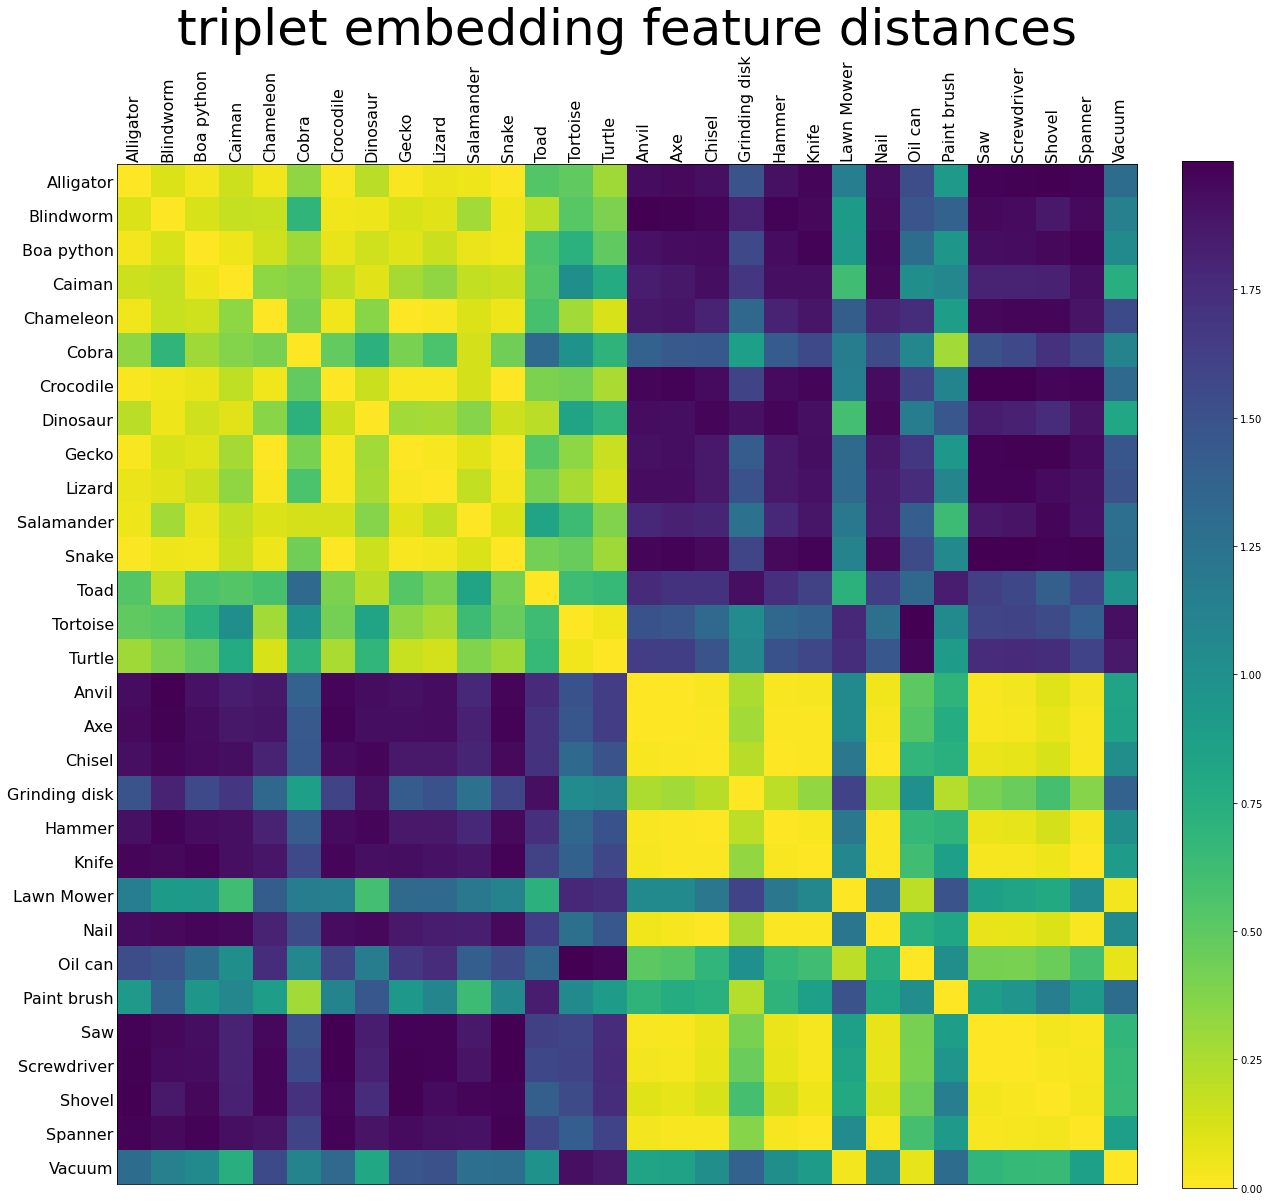

In [87]:
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()

Text(0, 0.5, ' dimension 2')

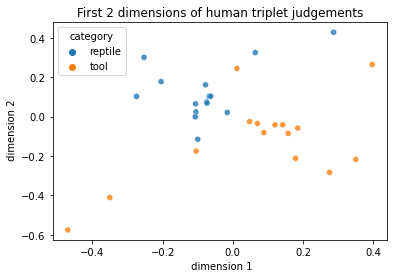

In [90]:
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')

### temperature 0

In [7]:
##load in GPT triplets

trips_df = pd.read_csv('../../results/reptile_tool/davinci_triplet_feature_list_temperature_0.csv', index_col=0).reset_index()

# remove rows in which the value of 'gpt_choice' is 'fill manually'
trips_df = trips_df[trips_df['gpt_choice']!='fill manually']

# ##concatenate data from both rounds of collection
# trips_df = pd.concat((trips_df_1,trips_df_2),axis=0)

## reformat the dataframe to be salmon friendly
heads = []
winners = []
losers =[]
for i, row in trips_df.iterrows():
    heads.append(row['Anchor'])
    winners.append(row['gpt_choice'])
    if row['Concept1']==row['gpt_choice']:
        losers.append(row['Concept2'])
    else:
        losers.append(row['Concept1'])
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})


In [9]:


## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

#### generate embeddings from gpt3 triplets

In [12]:
###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into

X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open('../../results/reptile_tool/reptile_tool_gpt_embeds_temp_0.pkl', 'wb') as f:
        pickle.dump(model, f)
    


NameError: name 'OfflineEmbedding' is not defined

## Human triplets

In [106]:
human_responses_1 = pd.read_csv('../../data/reptile_tool/reptile_tool_human_triplets.csv')
human_responses_2 = pd.read_csv('../../data/reptile_tool/reptile_tool_human_triplets_2.csv')

human_responses = pd.concat((human_responses_1,human_responses_2),axis=0)

In [110]:
valid_puids = human_responses.groupby('puid')['puid_num_responses'].max()==200
valid_puids = valid_puids[valid_puids==True].index

In [111]:
responses_clean = human_responses[human_responses.puid.isin(valid_puids)].reset_index(drop=True)

In [112]:
responses_clean.to_csv('../../data/reptile_tool/reptile_tool_human_triplets_clean.csv')

In [113]:
responses_clean

,head,left,right,winner,sampler,score,puid,response_time,network_latency,time_received,...,left_filename,right_filename,head_filename,winner_filename,loser_filename,time_received_since_start,datetime_received,start_time,puid_num_responses,num_responses
0,2,15,4,15,Random,-9999.0,9ebb7e54858df647,4.610,0.366,1.657608e+09,...,Lawn Mower,Boa python,Axe,Lawn Mower,Boa python,489.878654,2022-07-12T06:47:06.571000,1.657608e+09,1,1
1,13,2,11,2,Random,-9999.0,9ebb7e54858df647,2.113,0.144,1.657608e+09,...,Axe,Gecko,Hammer,Axe,Gecko,492.122653,2022-07-12T06:47:08.815000,1.657608e+09,2,2
2,6,0,18,0,Validation,1.0,9ebb7e54858df647,1.960,0.141,1.657608e+09,...,Alligator,Oil can,Chameleon,Alligator,Oil can,494.270653,2022-07-12T06:47:10.963000,1.657608e+09,3,3
3,11,24,18,24,Random,-9999.0,9ebb7e54858df647,2.146,0.165,1.657608e+09,...,Snake,Oil can,Gecko,Snake,Oil can,496.533653,2022-07-12T06:47:13.226000,1.657608e+09,4,4
4,28,9,19,9,Random,-9999.0,9ebb7e54858df647,2.122,0.136,1.657608e+09,...,Crocodile,Paint brush,Turtle,Crocodile,Paint brush,498.791653,2022-07-12T06:47:15.484000,1.657608e+09,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,3,16,20,16,Random,-9999.0,e9fd9e0b9a25233a,2.288,0.118,1.658780e+09,...,Lizard,Salamander,Blindworm,Lizard,Salamander,3758.644487,2022-07-25T20:09:34.938000,1.658776e+09,196,2109
3796,20,19,16,16,Random,-9999.0,e9fd9e0b9a25233a,2.457,0.219,1.658780e+09,...,Paint brush,Lizard,Salamander,Lizard,Paint brush,3761.317487,2022-07-25T20:09:37.611000,1.658776e+09,197,2110
3797,20,22,3,3,Random,-9999.0,e9fd9e0b9a25233a,1.814,0.222,1.658780e+09,...,Screwdriver,Blindworm,Salamander,Blindworm,Screwdriver,3763.255487,2022-07-25T20:09:39.549000,1.658776e+09,198,2111
3798,14,19,0,19,Validation,17.0,e9fd9e0b9a25233a,2.149,0.121,1.658780e+09,...,Paint brush,Alligator,Knife,Paint brush,Alligator,3765.629487,2022-07-25T20:09:41.923000,1.658776e+09,199,2112


In [114]:
X_train=responses_clean[responses_clean.sampler=='Random']
X_test=responses_clean[responses_clean.sampler=='Validation']

In [115]:
X_train = X_train[['head','winner','loser']].to_numpy()
X_test = X_test[['head','winner','loser']].to_numpy()

In [125]:
n = len(np.unique(responses_clean.left_filename)) ## number of items
d=3 ### dimensionality we're embedding into
fit_online=True

In [126]:
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open('../../results/reptile_tool/reptile_tool_human_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


initial score:  0.46857142448425293
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.469', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '1.002', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.655', 'score_test': '0.746', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '51.089', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.573', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '101.176', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.524', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '151.263', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.500', 'score_test': '0.783', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '201.350', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.488', 'score_test': '0.760', 'train_dat

In [127]:
human_embeddings_df = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(30,1),model.embedding_)))
human_embeddings_df.columns = ['concept','embed_1','embed_2','embed_3']
human_embeddings_df[['embed_1','embed_2','embed_3']]= human_embeddings_df[['embed_1','embed_2','embed_3']].astype('float64')

In [128]:
human_embeddings_df['category'] = human_embeddings_df.apply(lambda x: concept_to_category[x['concept']],axis=1)
human_embeddings_df = human_embeddings_df.sort_values(by = ['category','concept']).reset_index(drop=True)

human_embeddings_df.to_csv('../../data/reptile_tool/human_reptile_tool_embedding_df.csv')

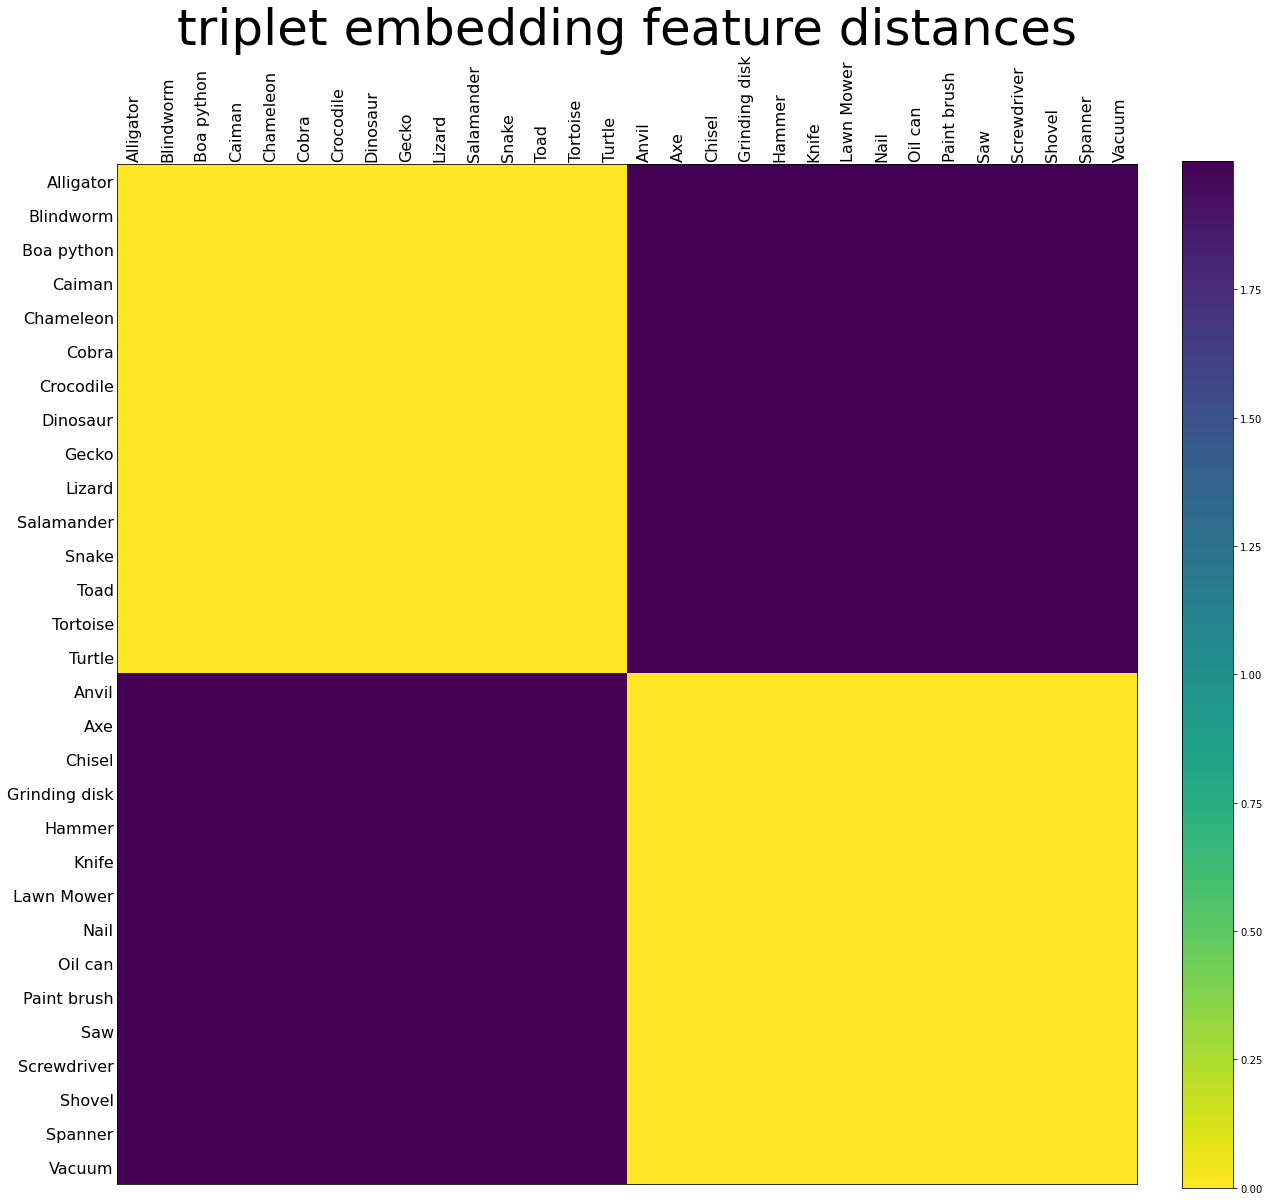

In [130]:
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(human_embeddings_df[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(human_embeddings_df.shape[0]),human_embeddings_df.concept,fontsize=16, rotation=90)
plt.yticks(range(human_embeddings_df.shape[0]),human_embeddings_df.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()

Text(0, 0.5, ' dimension 2')

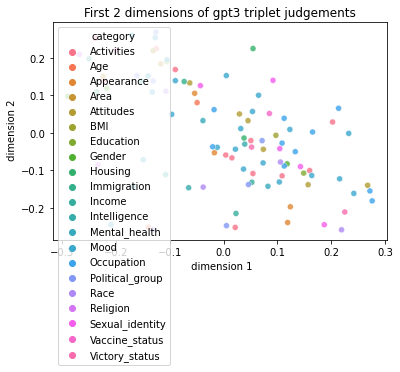

In [382]:
import seaborn as sns
sns.scatterplot(
            x="embed_2", y="embed_3",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=human_embeddings_df,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')

# Social Concepts

### GPT 3 triplets

In [355]:
##load in GPT triplets

trips_df = pd.read_csv('../../results/social_concepts/davinci_triplet_feature_list.csv', index_col=0).reset_index()


## reformat the dataframe to be salmon friendly
heads = []
winners = []
losers =[]
for i, row in trips_df.iterrows():
    
    ##check for nulls
    if type(row['Concept2'])==str and type(row['Concept1'])==str:
        heads.append(row['Anchor'].strip())
        winners.append(row['gpt_choice'])
        if row['Concept1']==row['gpt_choice']:
            losers.append(row['Concept2'].strip())
        else:
            losers.append(row['Concept1'].strip())
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})


In [356]:

## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

In [357]:
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

In [358]:
#### FOR LISA 

##create concept to category dict


maps = {('Driving',
'Fashion',
'Knitting',
'Karate',
'Woodworking',
'Reading',
'Shopping',
'Cooking',
'Robotics',
'Weightlifting',
'Yoga',
'Chess'): 'Activities',

('Baby',
'Adult'):'Age',
    
    ('Urban','Rural'):'Area',
        ('Confident',
'Angry',
'Jealous',
'Weak',
'Strong',
'Lazy',
'Hard-working'):'Attitudes',

          
        ('College','Dropout'):'Education',
        ('Man','Woman','Cis',):'Gender',
        ('Homeless','Homeowner'):'Housing',
        ('Citizen','Immigrant'): 'Immigration',
        ('Poor','Middle class', 'Wealthy','Poor '): 'Income',
        ('Dumb',
'Smart',
'Street-smart',
'Logical'):'Intelligence',
        ('Sane',
'Crazy',
'Anxious'): 'Mental_health',
        ('Aggressive ', 
         'Aggressive',
'Passive',
'Social',
'Lonely',
'Sympathetic',
'Pessimistic',
'Sad',
'Peaceful',
'Optimistic',
'Nerdy',
'Naughty',
'Moody',
'Happy',
'Good',
'Flirty',
'Energetic',
'Annoyed',
'Dirty',
'Cynical',
'Curious',
'Accomplished',
'Calm',
'Drunk'):'Mood',
        
        ('Nurse',
'Secretary',
'Doctor',
'Engineer',
'Student',
'Soldier',
'Scientist',
'Professor',
'Flight attendant',
'Pilot'):'Occupation',
        ('Beautiful',
'Ugly',
'Healthy',
'Unhealthy'):'Appearance',
        ('Republican',
'Democrat',
'Liberal',
'Conservative',
'Fascist',
'Socialist'):'Political_group',
('Hispanic',
'Caucasian',
'African American',
'American Indian',
'Asian'):'Race',
        ('Christian','Muslim'):'Religion',
        ('Gay',
'Lesbian',
'Heterosexual',
'Bisexual',
'Queer'):'Sexual_identity',
        ('Winner','Loser'):'Victory_status'
        
       }




concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v
concept_to_category['Obese'] = 'BMI'
concept_to_category['Vaccinated'] = 'Vaccine_status'
concept_to_category['Immune'] = 'Vaccine_status'

In [362]:
###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into

In [363]:
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)

In [364]:
fit_online=True

if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open('../../results/social_concepts/social_concepts_gpt_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


initial score:  0.47018030285835266
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.541', 'train_data': 14418, 'max_epochs': 8000, '_epochs': '1.003', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.657', 'score_test': '0.710', 'train_data': 14418, 'max_epochs': 8000, '_epochs': '51.163', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test': '0.604', 'score_test': '0.721', 'train_data': 14418, 'max_epochs': 8000, '_epochs': '101.322', '_elapsed_time': 7, 'batch_size': 128}
{'ident': '', 'loss_test': '0.577', 'score_test': '0.726', 'train_data': 14418, 'max_epochs': 8000, '_epochs': '151.482', '_elapsed_time': 10, 'batch_size': 128}
{'ident': '', 'loss_test': '0.561', 'score_test': '0.735', 'train_data': 14418, 'max_epochs': 8000, '_epochs': '201.641', '_elapsed_time': 14, 'batch_size': 128}
{'ident': '', 'loss_test': '0.551', 'score_test': '0.737', 'tr

In [365]:
embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')


Text(0, 0.5, ' dimension 2')

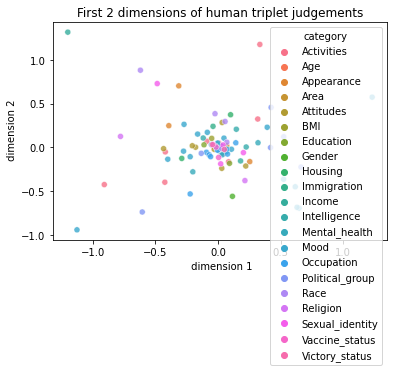

In [366]:
import seaborn as sns
sns.scatterplot(
            x="embed_2", y="embed_3",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of gpt3 triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')

In [367]:
embeddings_df_gpt.to_csv('../../data/social_concepts/gpt_social_concepts_embedding_df.csv')

### Human triplets

In [378]:
human_responses = pd.read_csv('../../data/social_concepts/social_concepts_human_triplets.csv')
valid_puids = human_responses.groupby('puid')['puid_num_responses'].max()==200
valid_puids = valid_puids[valid_puids==True].index

In [381]:
human_responses[human_responses.sampler=='Validation']

,head,left,right,winner,sampler,score,puid,response_time,network_latency,time_received,...,left_filename,right_filename,head_filename,winner_filename,loser_filename,time_received_since_start,datetime_received,start_time,puid_num_responses,num_responses
23,24,14,0,14,Validation,0.0,009c46b5fe388a11,2.102,0.357,1.658781e+09,...,Urban,Driving,College,Urban,Driving,337.547321,2022-07-25T20:26:13.136000,1.658780e+09,9,24
30,18,19,0,19,Validation,1.0,c1e339304d8f3290,2.088,0.290,1.658781e+09,...,Weak,Driving,Jealous,Weak,Driving,341.236321,2022-07-25T20:26:16.825000,1.658780e+09,5,31
33,7,15,0,0,Validation,2.0,4c6f016c7d4a7203,1.920,0.256,1.658781e+09,...,Rural,Driving,Cooking,Driving,Rural,343.430321,2022-07-25T20:26:19.019000,1.658780e+09,7,34
61,20,3,0,3,Validation,5.0,4c6f016c7d4a7203,0.174,0.131,1.658781e+09,...,Karate,Driving,Strong,Karate,Driving,355.824321,2022-07-25T20:26:31.413000,1.658780e+09,21,62
67,6,0,18,0,Validation,4.0,c1e339304d8f3290,2.886,0.241,1.658781e+09,...,Driving,Jealous,Shopping,Driving,Jealous,357.304321,2022-07-25T20:26:32.893000,1.658780e+09,7,68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11254,18,27,0,27,Validation,2.0,bb35675a56c54c81,3.097,0.091,1.658785e+09,...,Woman,Driving,Jealous,Woman,Driving,5036.726321,2022-07-25T21:44:32.315000,1.658780e+09,103,11255
11255,20,0,3,3,Validation,3.0,bb35675a56c54c81,2.395,0.158,1.658785e+09,...,Driving,Karate,Strong,Karate,Driving,5039.279321,2022-07-25T21:44:34.868000,1.658780e+09,104,11256
11257,28,0,23,23,Validation,4.0,bb35675a56c54c81,2.564,0.090,1.658785e+09,...,Driving,Obese,Cis,Obese,Driving,5043.706321,2022-07-25T21:44:39.295000,1.658780e+09,106,11258
11279,24,0,7,0,Validation,5.0,335befb26d2bde88,3.481,0.210,1.658786e+09,...,Driving,Cooking,College,Driving,Cooking,5104.412321,2022-07-25T21:45:40.001000,1.658780e+09,3,11280


In [322]:
responses_clean = human_responses[human_responses.puid.isin(valid_puids)].reset_index(drop=True)
responses_clean.to_csv('../../data/social_concepts/social_concepts_human_triplets_clean.csv')

In [323]:
responses_clean

,head,left,right,winner,sampler,score,puid,response_time,network_latency,time_received,...,left_filename,right_filename,head_filename,winner_filename,loser_filename,time_received_since_start,datetime_received,start_time,puid_num_responses,num_responses
0,12,23,74,23,Random,-9999.0,473f448cb2ab2122,10.333,0.205,1.658781e+09,...,Obese,Flight attendant,Baby,Obese,Flight attendant,305.246321,2022-07-25T20:25:40.835000,1.658780e+09,1,1
1,17,79,5,79,Random,-9999.0,473f448cb2ab2122,5.371,0.223,1.658781e+09,...,Unhealthy,Reading,Angry,Unhealthy,Reading,310.835321,2022-07-25T20:25:46.424000,1.658780e+09,2,2
2,87,35,56,56,Random,-9999.0,fe45e6534c29bb04,13.940,0.188,1.658781e+09,...,Middleーclass,Happy,Caucasian,Happy,Middleーclass,319.108321,2022-07-25T20:25:54.697000,1.658780e+09,1,5
3,59,8,52,8,Random,-9999.0,fe45e6534c29bb04,4.076,0.189,1.658781e+09,...,Robotics,Optimistic,Energetic,Robotics,Optimistic,323.374321,2022-07-25T20:25:58.963000,1.658780e+09,2,7
4,10,100,68,68,Random,-9999.0,c1e339304d8f3290,42.323,1.288,1.658781e+09,...,Winner,Doctor,Yoga,Doctor,Winner,326.033321,2022-07-25T20:26:01.622000,1.658780e+09,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,47,22,47,Random,-9999.0,e7a6e9dc1a465aa3,1.851,0.149,1.658785e+09,...,Lonely,Hard-working,Ugly,Lonely,Hard-working,4956.717321,2022-07-25T21:43:12.306000,1.658780e+09,196,11226
9996,95,21,76,76,Random,-9999.0,e7a6e9dc1a465aa3,4.116,0.086,1.658785e+09,...,Lazy,Beautiful,Heterosexual,Beautiful,Lazy,4960.978321,2022-07-25T21:43:16.567000,1.658780e+09,197,11229
9997,70,98,0,98,Random,-9999.0,e7a6e9dc1a465aa3,2.230,0.155,1.658785e+09,...,Vaccinated,Driving,Student,Vaccinated,Driving,4963.363321,2022-07-25T21:43:18.952000,1.658780e+09,198,11231
9998,11,19,61,19,Random,-9999.0,e7a6e9dc1a465aa3,2.854,0.157,1.658785e+09,...,Weak,Dirty,Chess,Weak,Dirty,4966.372321,2022-07-25T21:43:21.961000,1.658780e+09,199,11233


In [369]:
X_train=responses_clean[responses_clean.sampler=='Random']
X_test=responses_clean[responses_clean.sampler=='Validation']

X_train = X_train[['head','winner','loser']].to_numpy()
X_test = X_test[['head','winner','loser']].to_numpy()

In [371]:
n = X_train.max()+1 ## number of items
d=3 ### dimensionality we're embedding into
fit_online=True

In [372]:
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=100)
    model.fit(X_train, X_test)
    with open('../../results/social_concepts/social_concepts_human_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


initial score:  0.48797595500946045
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.499', 'train_data': 9002, 'max_epochs': 8000, '_epochs': '1.010', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.685', 'score_test': '0.609', 'train_data': 9002, 'max_epochs': 8000, '_epochs': '101.965', '_elapsed_time': 4, 'batch_size': 128}
{'ident': '', 'loss_test': '0.678', 'score_test': '0.609', 'train_data': 9002, 'max_epochs': 8000, '_epochs': '202.920', '_elapsed_time': 8, 'batch_size': 128}
{'ident': '', 'loss_test': '0.679', 'score_test': '0.609', 'train_data': 9002, 'max_epochs': 8000, '_epochs': '303.876', '_elapsed_time': 12, 'batch_size': 128}
{'ident': '', 'loss_test': '0.679', 'score_test': '0.566', 'train_data': 9002, 'max_epochs': 8000, '_epochs': '404.831', '_elapsed_time': 16, 'batch_size': 128}
{'ident': '', 'loss_test': '0.677', 'score_test': '0.566', 'train_

In [373]:
human_embeddings_df = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(102,1),model.embedding_)))
human_embeddings_df.columns = ['concept','embed_1','embed_2','embed_3']
human_embeddings_df[['embed_1','embed_2','embed_3']]= human_embeddings_df[['embed_1','embed_2','embed_3']].astype('float64')

Text(0, 0.5, ' dimension 2')

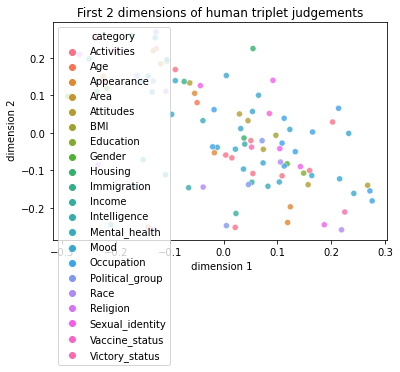

In [375]:
human_embeddings_df['category'] = human_embeddings_df.apply(lambda x: concept_to_category[x['concept']],axis=1)
human_embeddings_df = human_embeddings_df.sort_values(by = ['category','concept']).reset_index(drop=True)


import seaborn as sns
sns.scatterplot(
            x="embed_2", y="embed_3",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=human_embeddings_df,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')

In [376]:

human_embeddings_df.to_csv('../../data/social_concepts/human_social_concepts_embedding_df.csv')

# Flan-xxl CoT Triplets

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding

shape of the triplet dataframe:  (2450, 3)
initial score:  0.5224489569664001
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.563', 'train_data': 1960, 'max_epochs': 8000, '_epochs': '1.045', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.683', 'score_test': '0.688', 'train_data': 1960, 'max_epochs': 8000, '_epochs': '53.290', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.647', 'score_test': '0.680', 'train_data': 1960, 'max_epochs': 8000, '_epochs': '105.535', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.619', 'score_test': '0.686', 'train_data': 1960, 'max_epochs': 8000, '_epochs': '157.780', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.600', 'score_test': '0.686', 'train_data': 1960, 'max_epochs': 8000, '_epochs': '210.024', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test': 

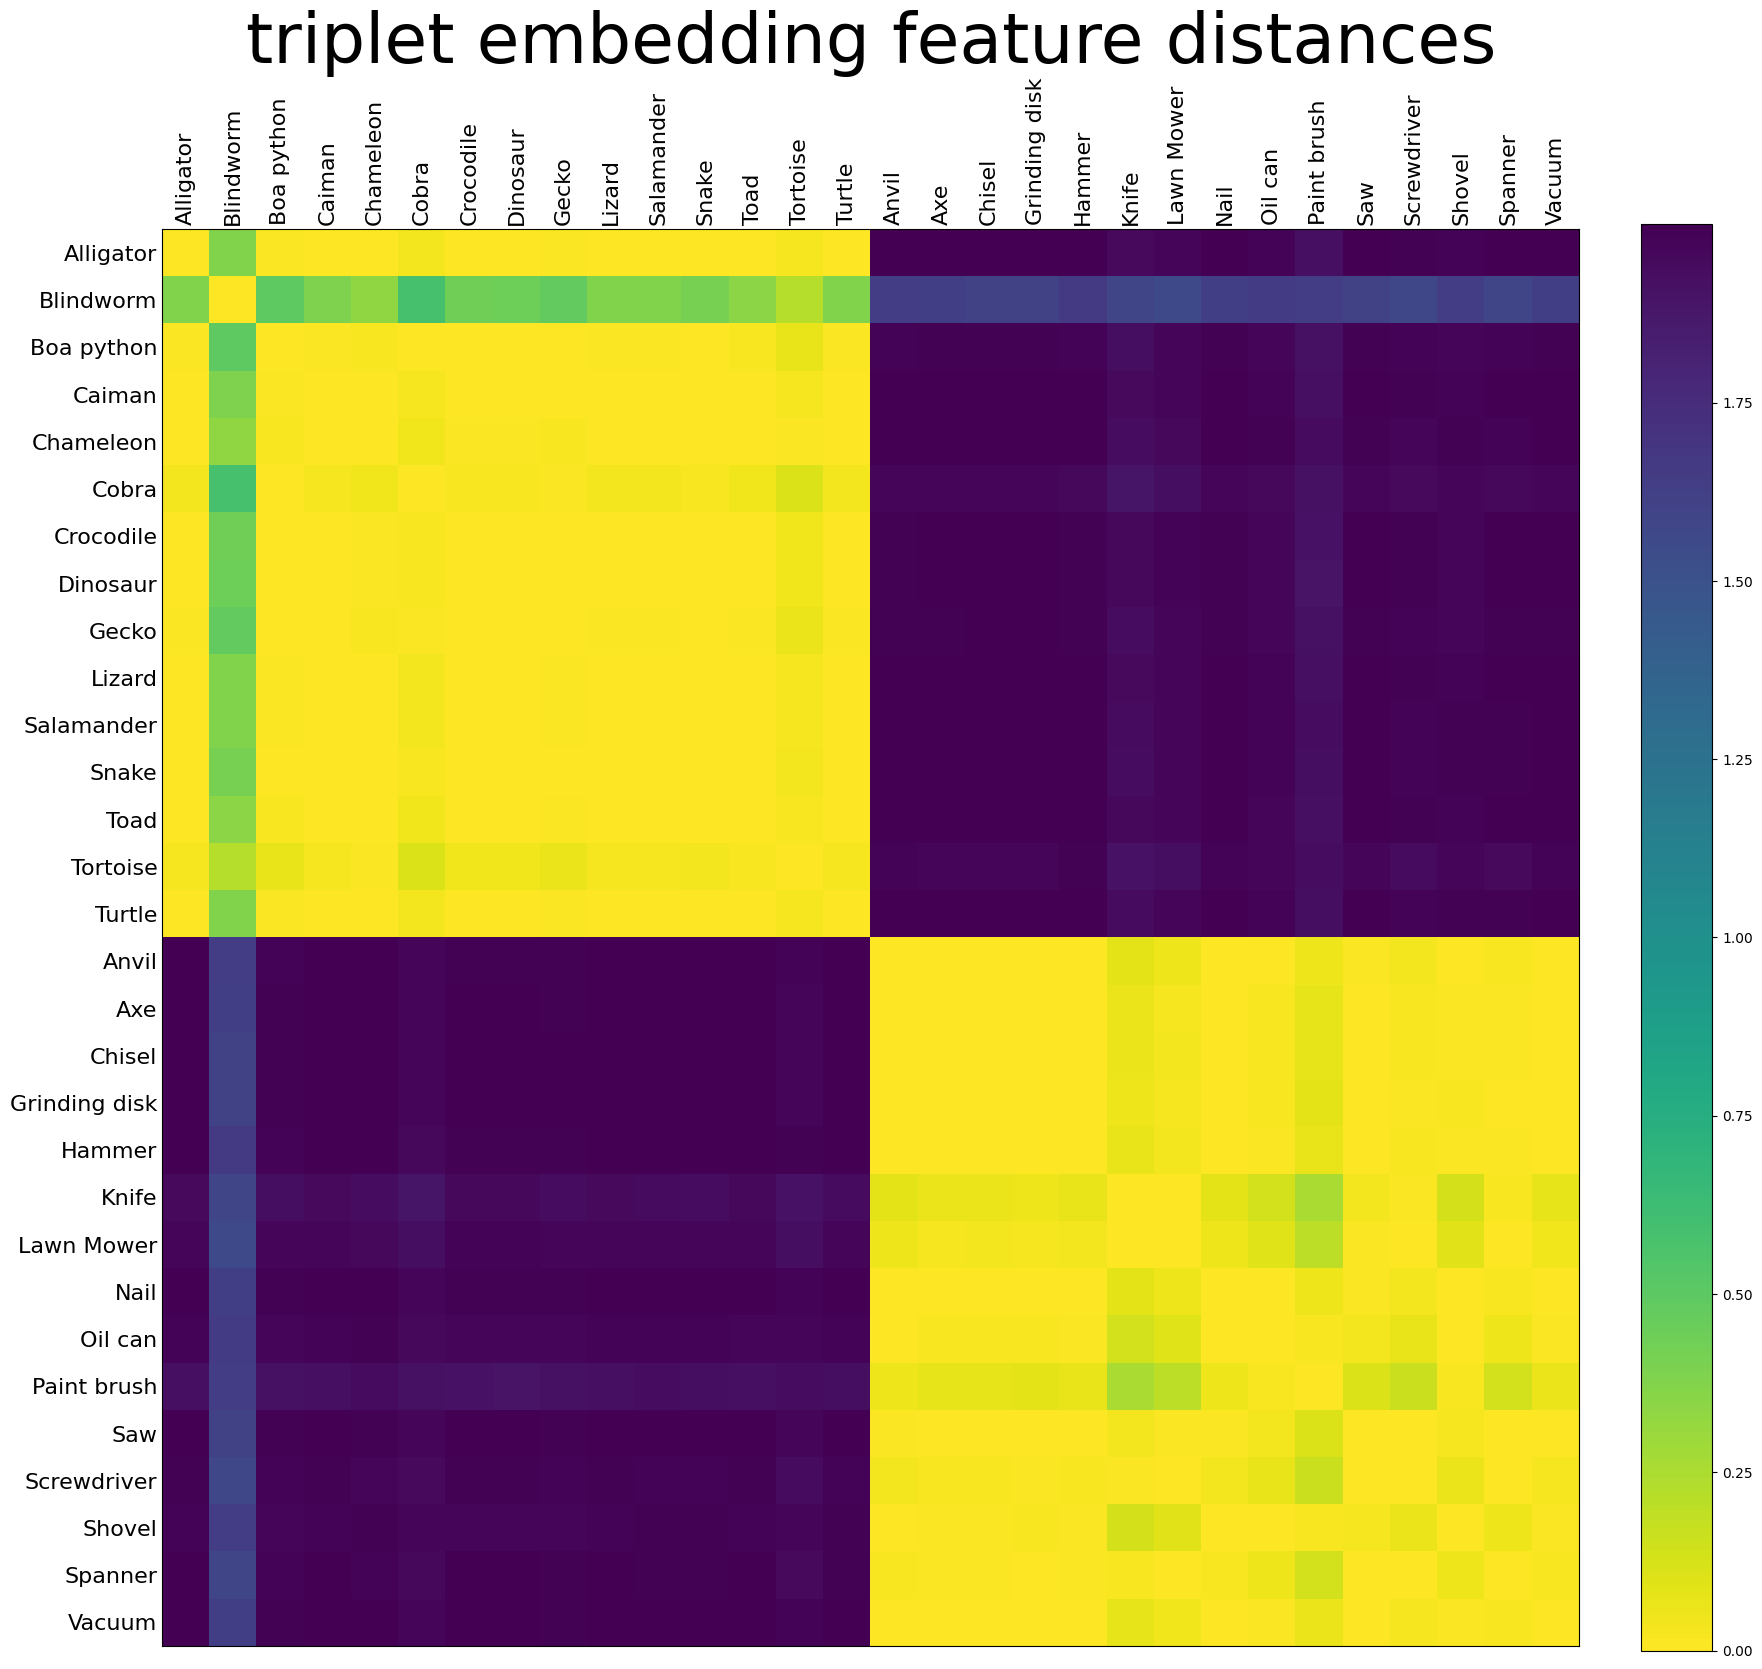

30

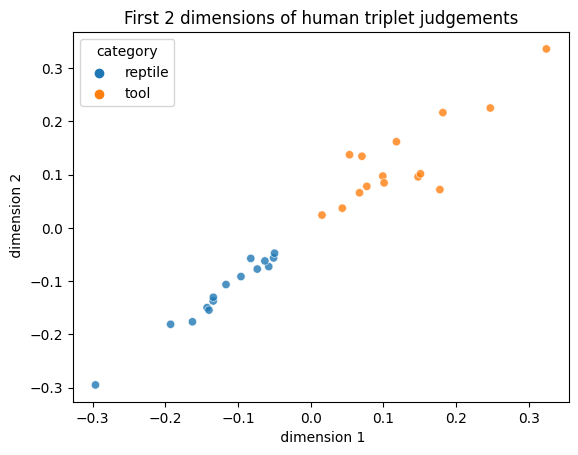

In [93]:
model_fname = 'flan_xxl_cot'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/flan-xxl/flan-t5-xxl_cot_triplet.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'response', 'answer']

heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    if row['response'] != '': 
        try:
            row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
        except:
            continue
    else:
        continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))


# text-davinci-003 CoT Triplets

shape of the triplet dataframe:  (2644, 3)
initial score:  0.47637051343917847
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.471', 'train_data': 2115, 'max_epochs': 8000, '_epochs': '1.029', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.688', 'score_test': '0.711', 'train_data': 2115, 'max_epochs': 8000, '_epochs': '52.471', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.658', 'score_test': '0.715', 'train_data': 2115, 'max_epochs': 8000, '_epochs': '103.913', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.630', 'score_test': '0.715', 'train_data': 2115, 'max_epochs': 8000, '_epochs': '155.355', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.609', 'score_test': '0.715', 'train_data': 2115, 'max_epochs': 8000, '_epochs': '206.797', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test':

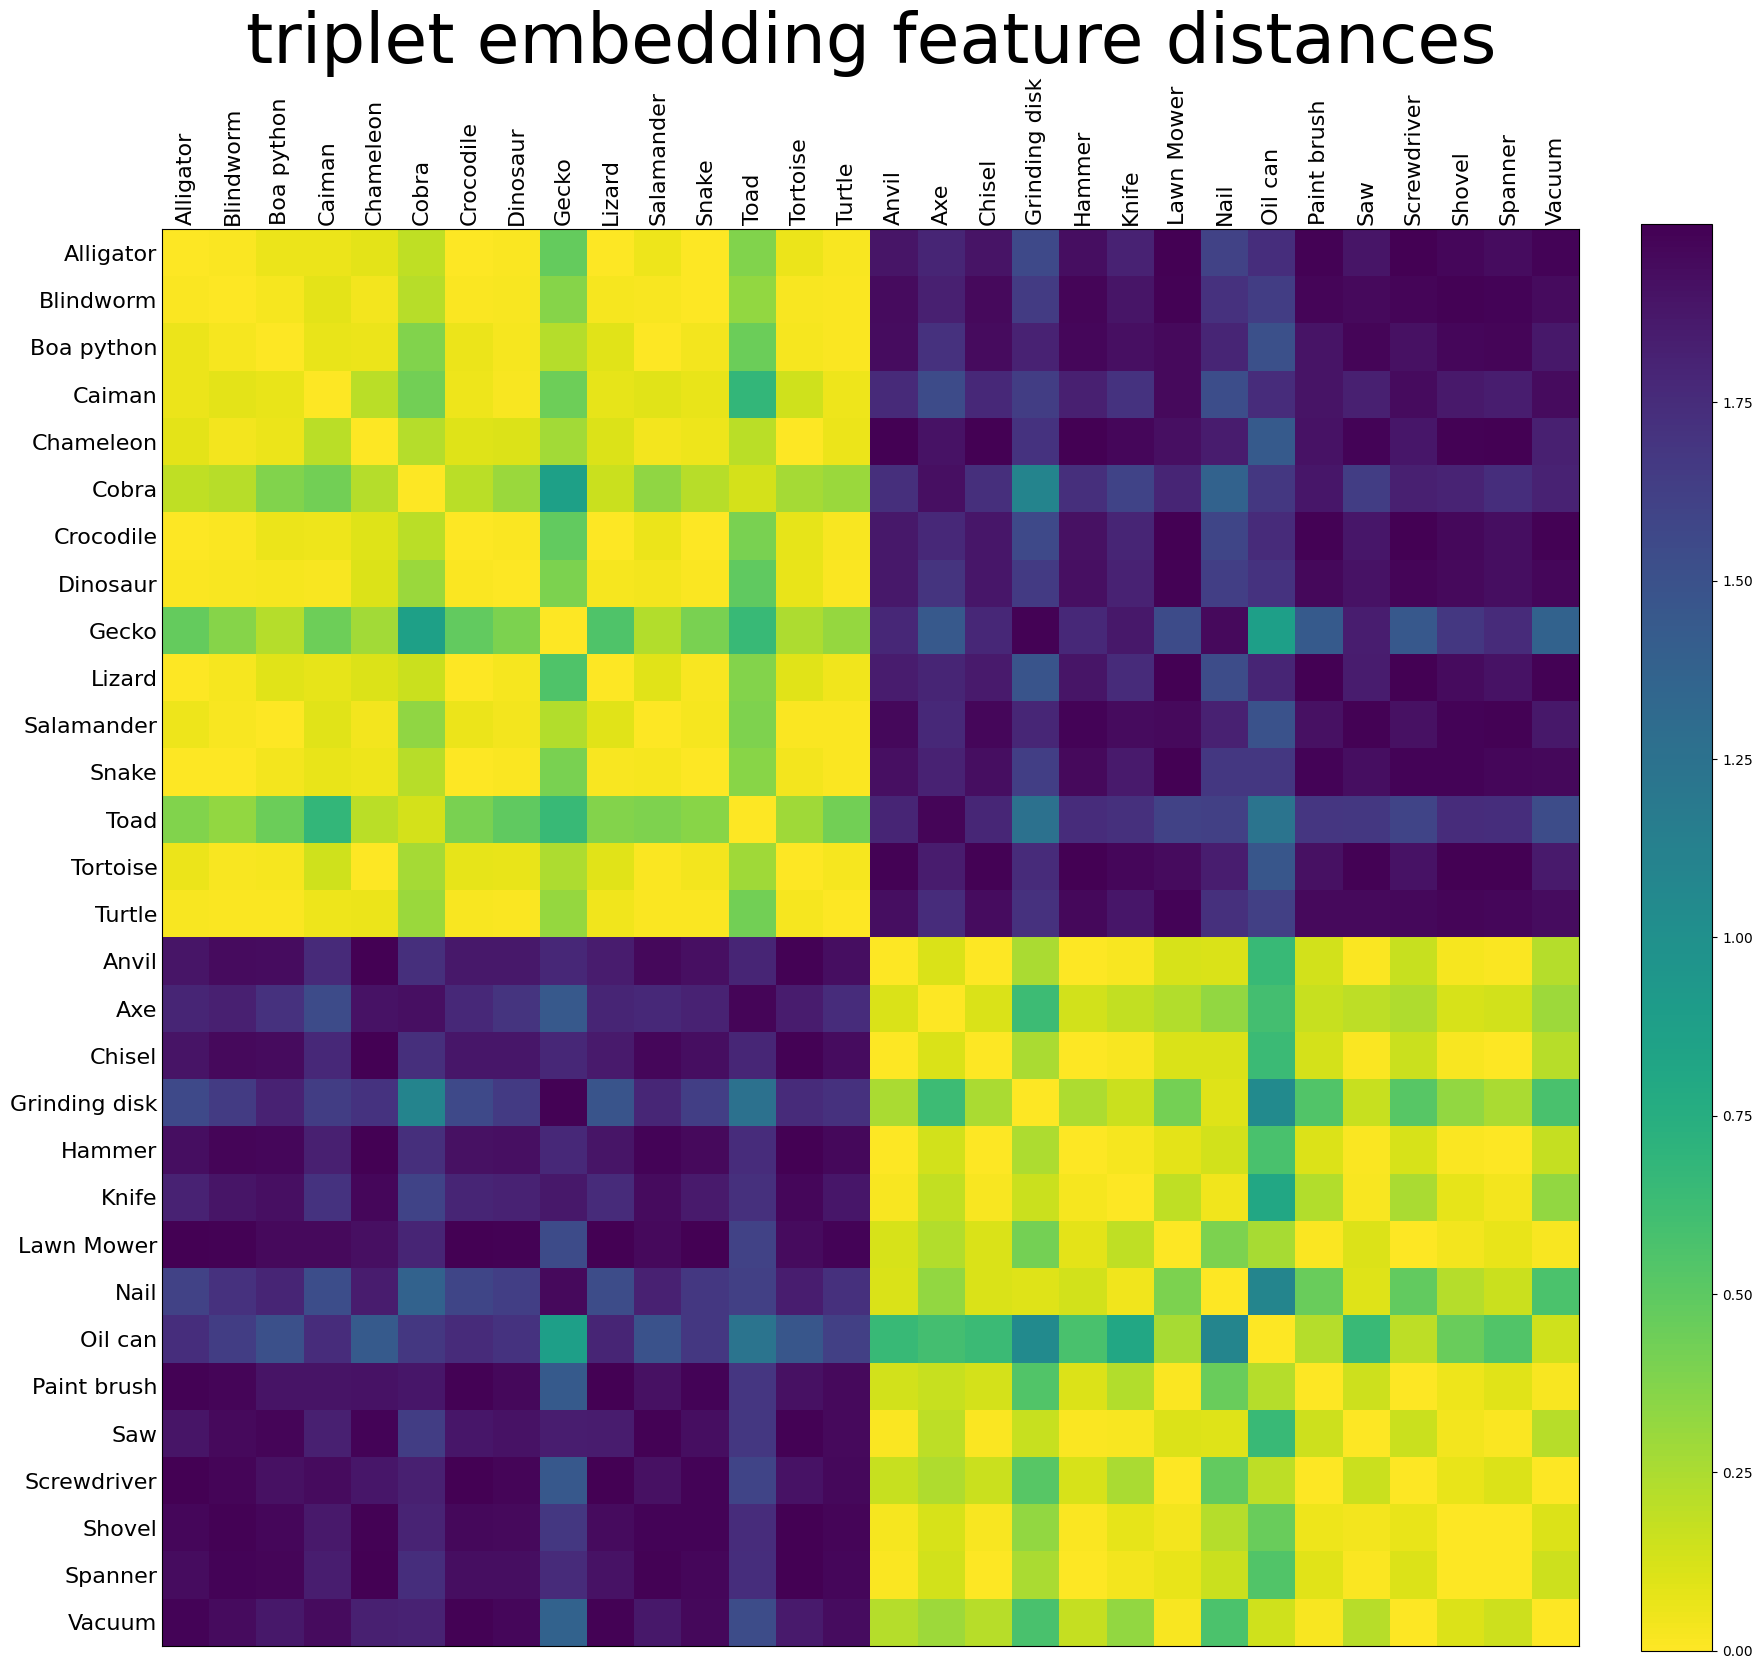

30

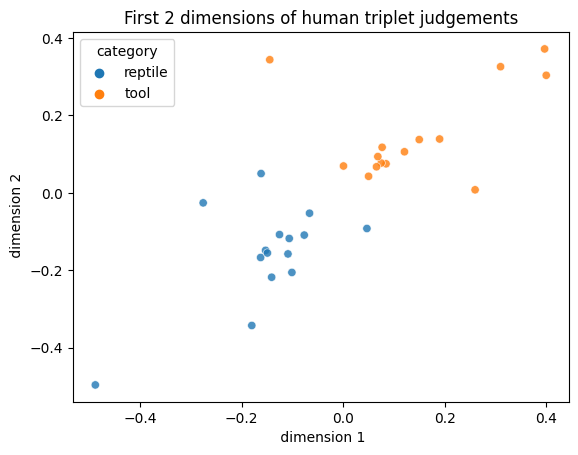

In [94]:

import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'text-davinci-003_cot'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/text-davinci-003/text-davinci-003_cot_triplet.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'response', 'answer']

heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    if row['response'] != '': 
        try:
            row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
        except:
            continue
    else:
        continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))


# text-davinci-002 CoT Triplets

In [ ]:

import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'text-davinci-002_cot'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/text-davinici-002/gpt-semantics_cot_triplet.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'response', 'answer']

heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    if row['response'] != '': 
        try:
            row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
        except:
            continue
    else:
        continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))


shape of the triplet dataframe:  (2185, 3)
initial score:  0.5171624422073364
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.515', 'train_data': 1748, 'max_epochs': 8000, '_epochs': '1.025', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.692', 'score_test': '0.675', 'train_data': 1748, 'max_epochs': 8000, '_epochs': '52.284', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.682', 'score_test': '0.664', 'train_data': 1748, 'max_epochs': 8000, '_epochs': '103.542', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.668', 'score_test': '0.666', 'train_data': 1748, 'max_epochs': 8000, '_epochs': '154.801', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.655', 'score_test': '0.670', 'train_data': 1748, 'max_epochs': 8000, '_epochs': '206.059', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': 

# flan-ul2 Triplets

Caiman Crocodile Shovel dangerous
Gecko Salamander Alligator amphibian
Boa python Turtle Cobra snake
Lizard Spanner Paint brush shape
Caiman Tortoise Toad toad
Cobra Shovel Chameleon shape
Chisel Grinding disk Anvil Anvil
Anvil Axe Blindworm name
Lizard Toad Anvil shape
Caiman Knife Snake shape
Caiman Crocodile Knife knife
Turtle Vacuum Lizard Lizard
Chisel Knife Gecko gecko
Blindworm Oil can Grinding disk oil
Grinding disk Turtle Crocodile shape
Knife Lawn Mower Nail common
Knife Oil can Snake Snake
Cobra Toad Shovel size
Blindworm Lawn Mower Alligator alligator
Cobra Salamander Crocodile deadly
Paint brush Saw Chisel tool
Blindworm Knife Grinding disk shape
Gecko Salamander Saw reptile
Lawn Mower Vacuum Knife Knife
Hammer Screwdriver Grinding disk tool
Paint brush Tortoise Toad toad
Snake Toad Oil can oil
Gecko Vacuum Axe Axe
Boa python Toad Chameleon chameleon
Gecko Turtle Lizard Lizard
Crocodile Grinding disk Anvil Anvil
Salamander Turtle Axe shape
Caiman Cobra Blindworm venom
Liza

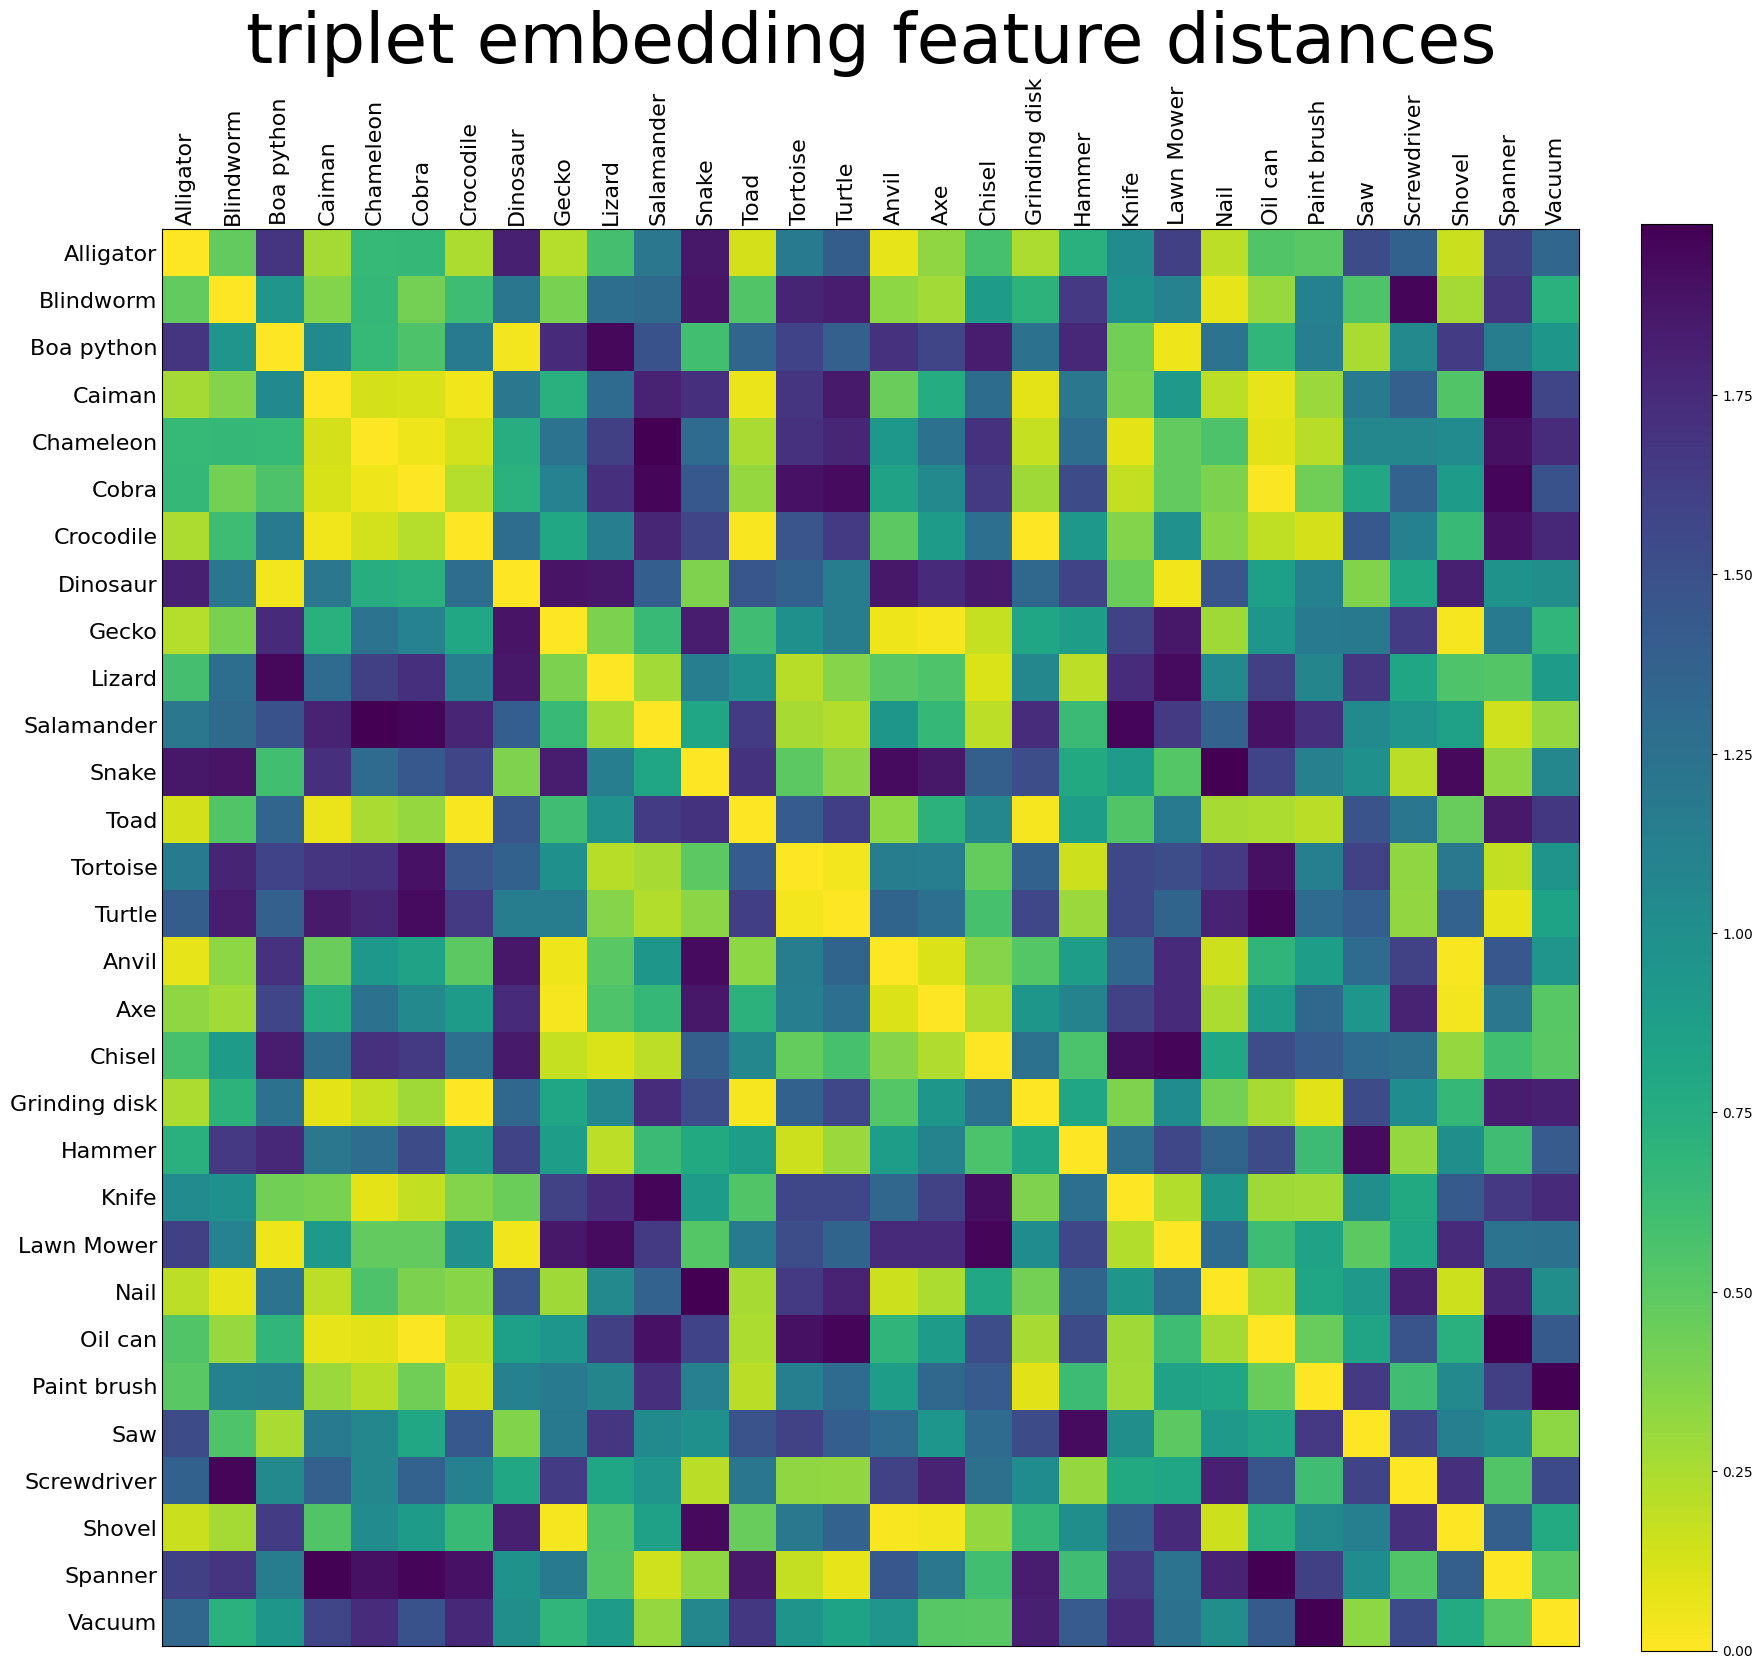

30

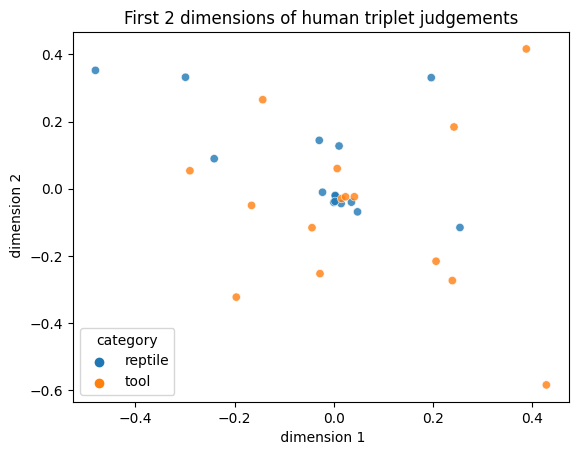

In [5]:

import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'flan-ul2'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/flan-ul2/flan-ul2_triplet.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'answer']

heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    # if row['response'] != '': 
    #     try:
    #         row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
    #     except:
    #         continue
    # else:
    #     continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        print(left, right, anchor, row['answer'])
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))


# flan-t5-xxl Triplets

shape of the triplet dataframe:  (2352, 3)
initial score:  0.5095541477203369
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.524', 'train_data': 1881, 'max_epochs': 8000, '_epochs': '1.021', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.685', 'score_test': '0.669', 'train_data': 1881, 'max_epochs': 8000, '_epochs': '52.057', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.667', 'score_test': '0.711', 'train_data': 1881, 'max_epochs': 8000, '_epochs': '103.094', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.658', 'score_test': '0.707', 'train_data': 1881, 'max_epochs': 8000, '_epochs': '154.131', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.648', 'score_test': '0.705', 'train_data': 1881, 'max_epochs': 8000, '_epochs': '205.167', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test': 

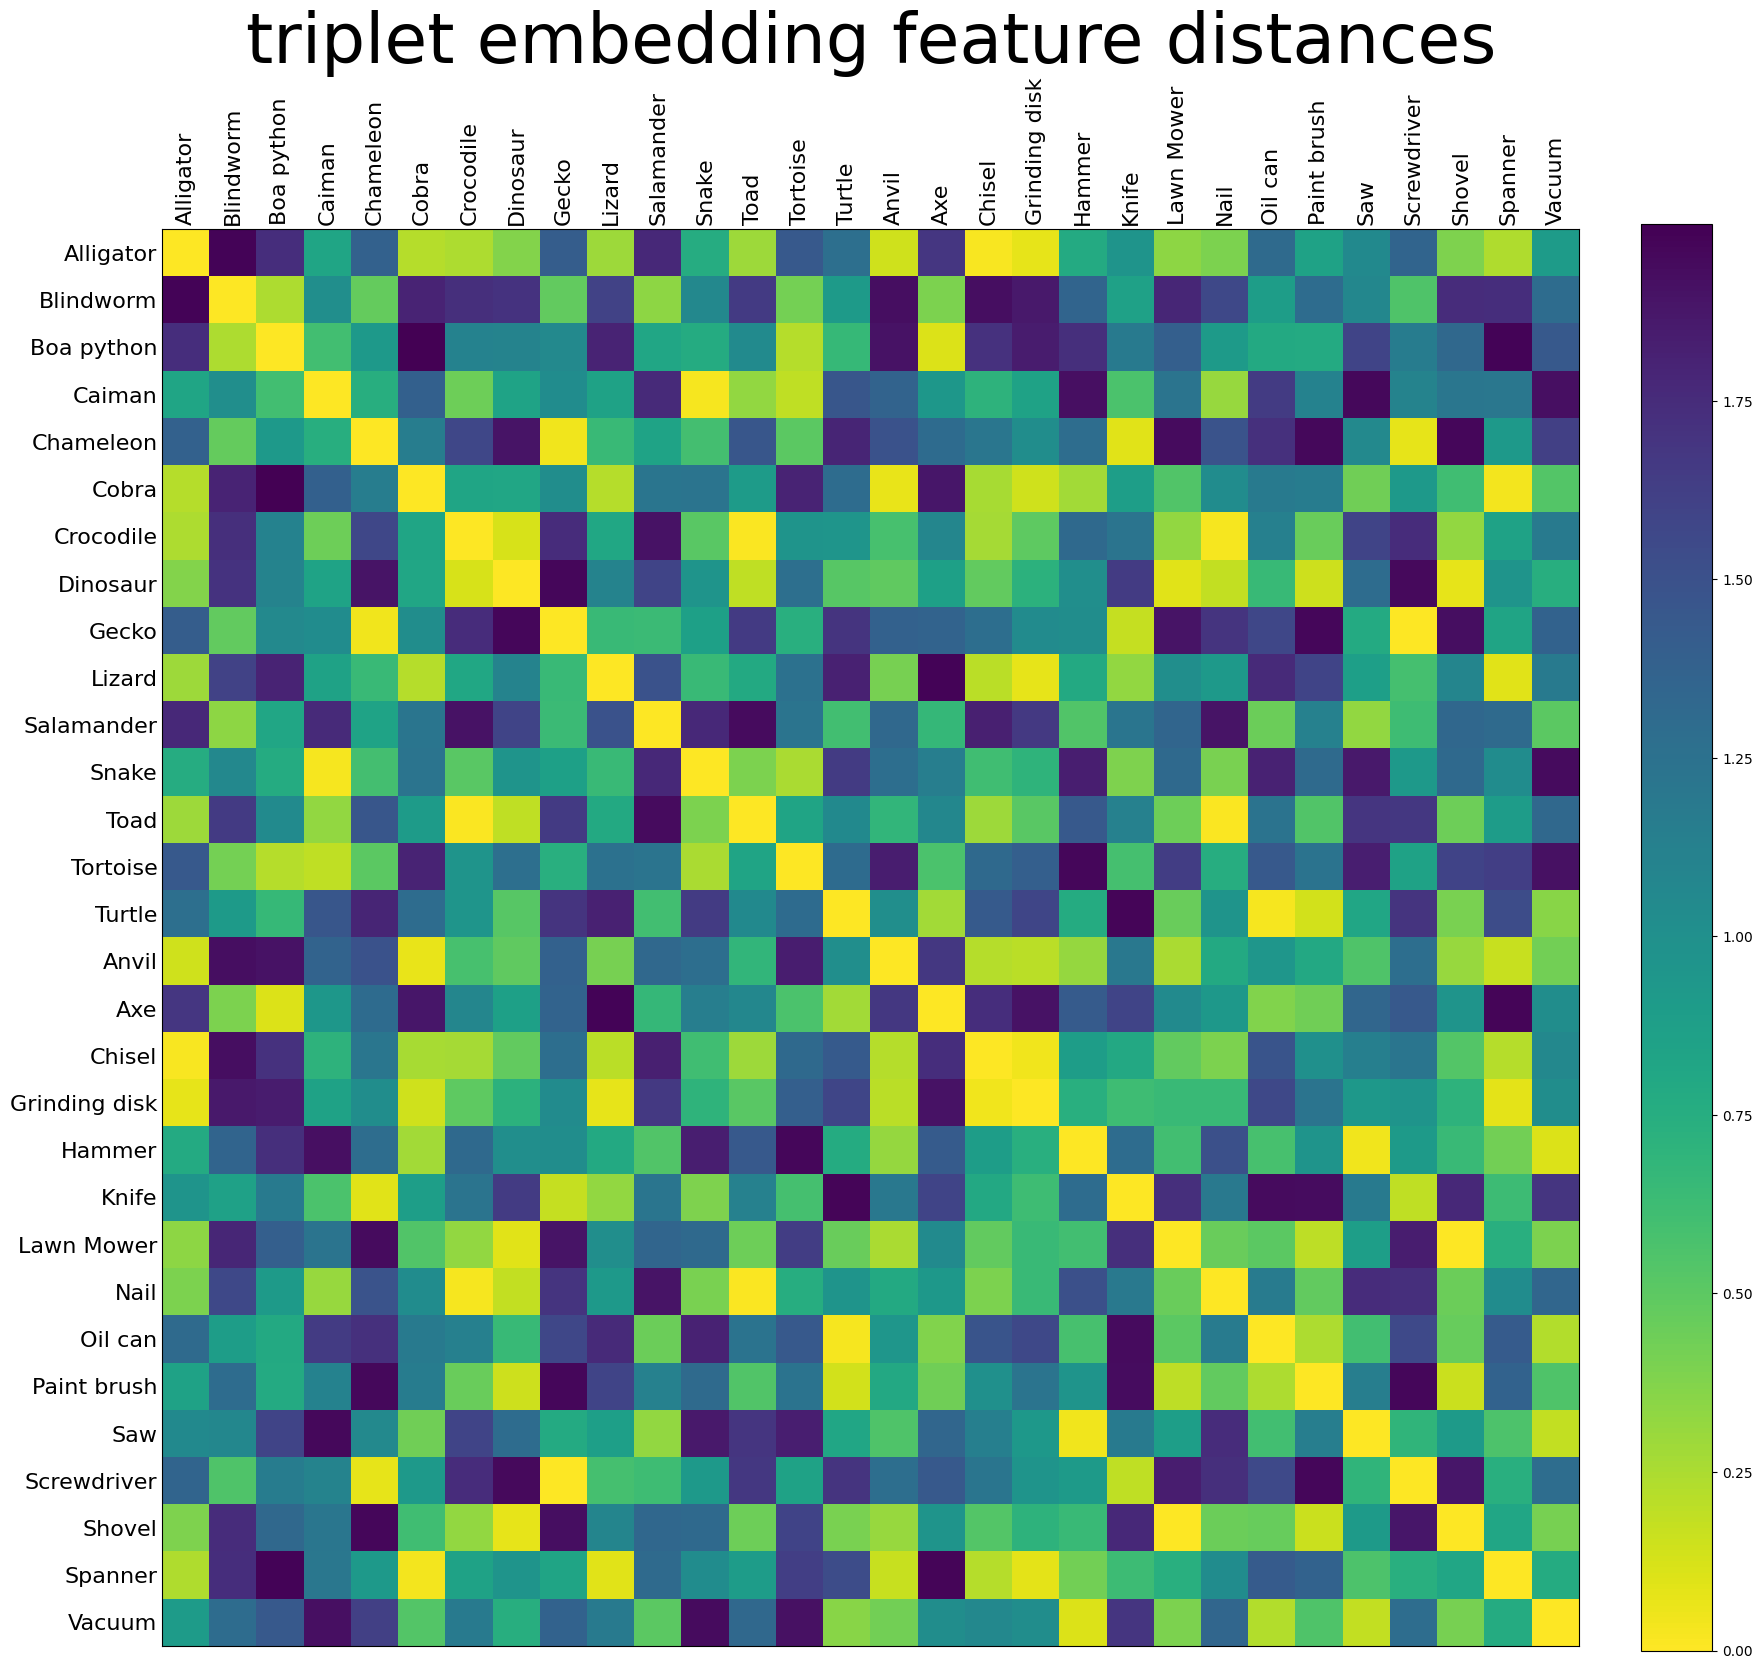

30

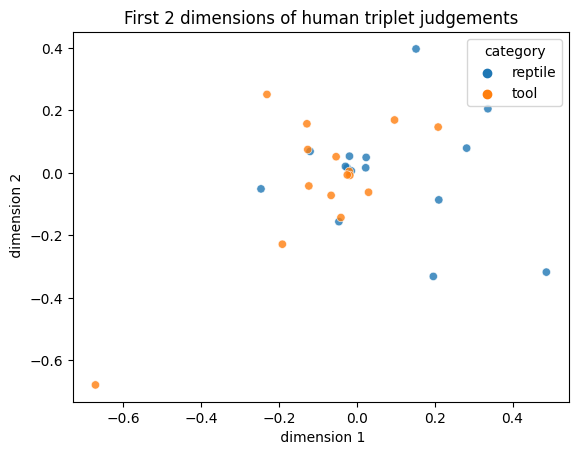

In [12]:


import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'flan-t5-xxl'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/flan-xxl/flan-t5-xxl_triplet.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'answer']

heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    # if row['response'] != '': 
    #     try:
    #         row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
    #     except:
    #         continue
    # else:
    #     continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only only word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only only word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only only word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        # print(left, right, anchor, row['answer'])
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))


# flan-ul2-triplet

shape of the triplet dataframe:  (2576, 3)
initial score:  0.47480618953704834
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.506', 'train_data': 2060, 'max_epochs': 8000, '_epochs': '1.056', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.685', 'score_test': '0.779', 'train_data': 2060, 'max_epochs': 8000, '_epochs': '53.872', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.650', 'score_test': '0.767', 'train_data': 2060, 'max_epochs': 8000, '_epochs': '106.687', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.618', 'score_test': '0.767', 'train_data': 2060, 'max_epochs': 8000, '_epochs': '159.503', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.591', 'score_test': '0.766', 'train_data': 2060, 'max_epochs': 8000, '_epochs': '212.318', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test':

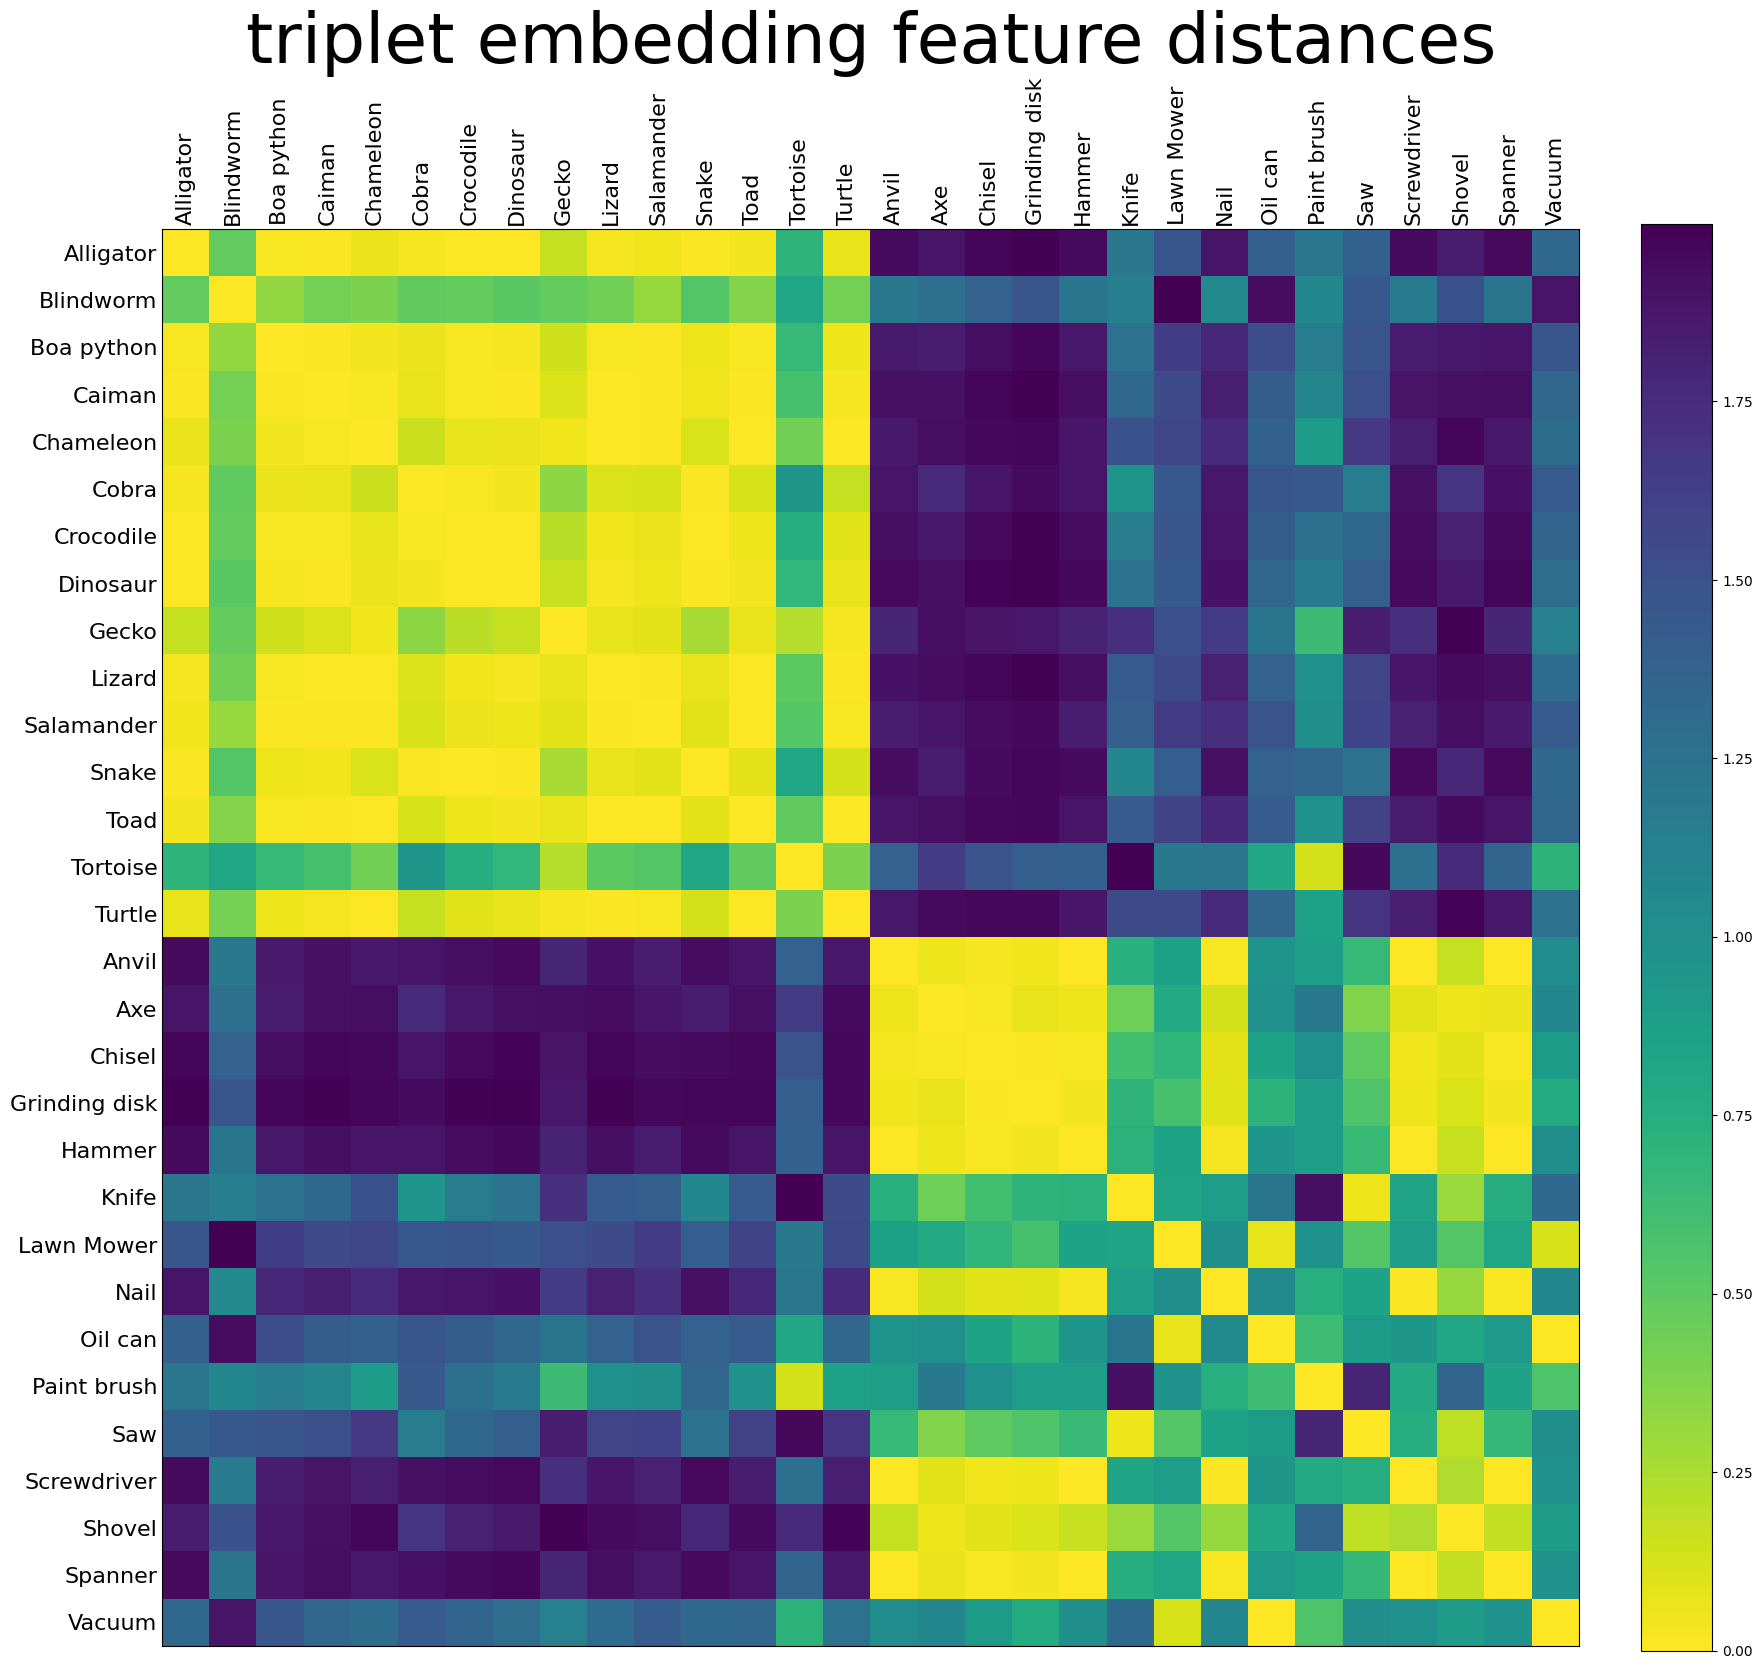

30

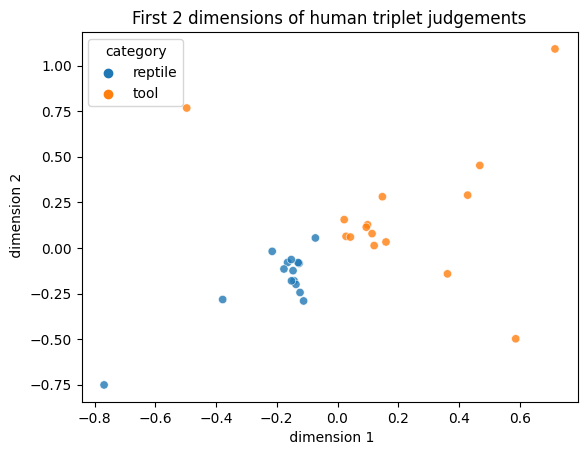

In [11]:



import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'flan-ul2-cot'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/flan-ul2/flan-ul2_cot_triplet.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'response', 'answer']

heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    # if row['response'] != '': 
    #     try:
    #         row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
    #     except:
    #         continue
    # else:
    #     continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        # print(left, right, anchor, row['answer'])
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))



#  text-davinci-003 triplet

shape of the triplet dataframe:  (2323, 3)
initial score:  0.47741934657096863
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.516', 'train_data': 1858, 'max_epochs': 8000, '_epochs': '1.033', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.685', 'score_test': '0.748', 'train_data': 1858, 'max_epochs': 8000, '_epochs': '52.702', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.652', 'score_test': '0.770', 'train_data': 1858, 'max_epochs': 8000, '_epochs': '104.370', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.625', 'score_test': '0.776', 'train_data': 1858, 'max_epochs': 8000, '_epochs': '156.039', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.600', 'score_test': '0.783', 'train_data': 1858, 'max_epochs': 8000, '_epochs': '207.707', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test':

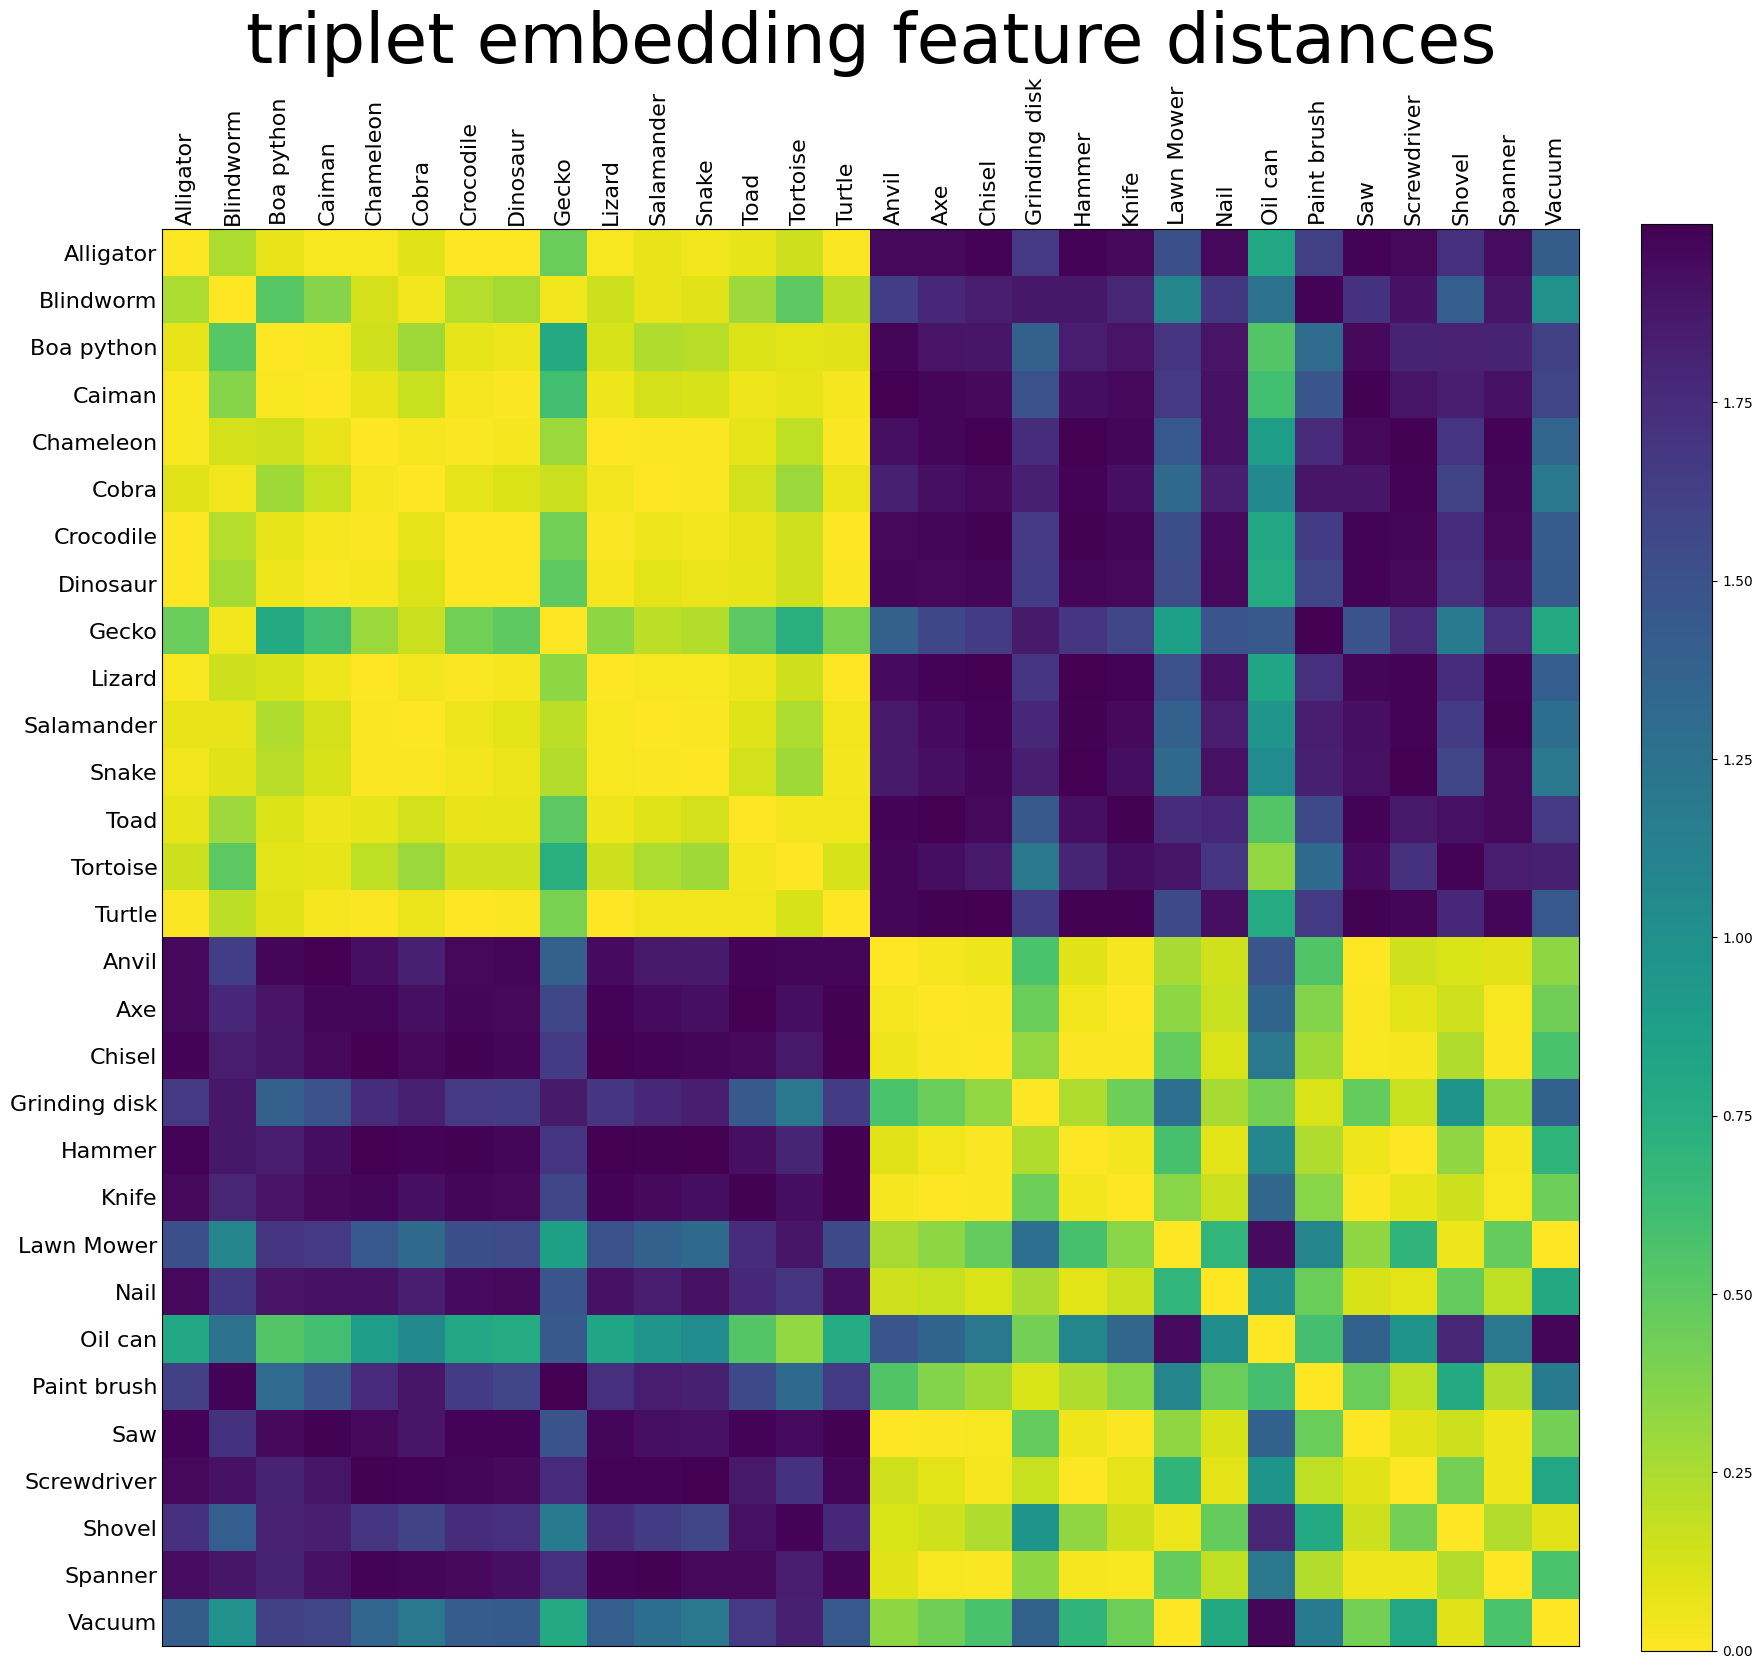

30

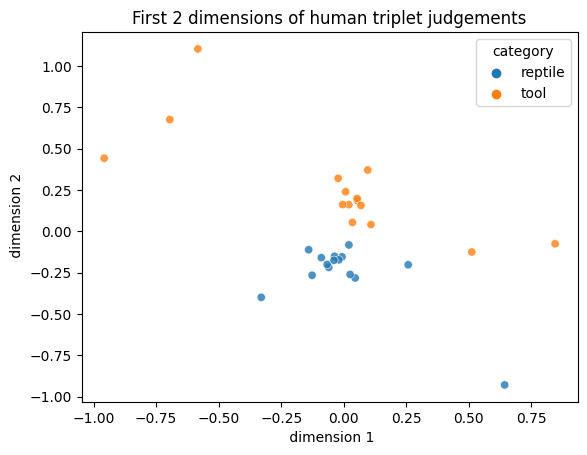

In [5]:
import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'text_davinci_003'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/text-davinci-003/triplet_response_davinci-003.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'answer']

heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    # if row['response'] != '': 
    #     try:
    #         row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
    #     except:
    #         continue
    # else:
    #     continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if type(row['answer']) != str:
        continue
    if '.' in row['answer']:
        row['answer'] = row['answer'].split('.')[0]
    else:
        pass
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        # print(left, right, anchor, row['answer'])
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))



# rebuttal

## human triplets different dim

In [13]:
concepts = ['Alligator', 'Anvil', 'Axe', 'Blindworm', 'Boa python', 'Caiman', 'Chameleon', 'Chisel', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko', 'Grinding disk', 'Hammer', 'Knife', 'Lawn Mower', 'Lizard', 'Nail', 'Oil can', 'Paint brush', 'Salamander', 'Saw', 'Screwdriver', 'Shovel', 'Snake', 'Spanner', 'Toad', 'Tortoise', 'Turtle', 'Vacuum']

In [26]:
## Human triplets
human_responses_1 = pd.read_csv('../../data/reptile_tool/reptile_tool_human_triplets.csv')
human_responses_2 = pd.read_csv('../../data/reptile_tool/reptile_tool_human_triplets_2.csv')

human_responses = pd.concat((human_responses_1,human_responses_2),axis=0)
valid_puids = human_responses.groupby('puid')['puid_num_responses'].max()==200
valid_puids = valid_puids[valid_puids==True].index
responses_clean = human_responses[human_responses.puid.isin(valid_puids)].reset_index(drop=True)
# responses_clean.to_csv('../../data/reptile_tool/reptile_tool_human_triplets_clean.csv')
responses_clean
X_train=responses_clean[responses_clean.sampler=='Random']
X_test=responses_clean[responses_clean.sampler=='Validation']
X_train = X_train[['head','winner','loser']].to_numpy()
X_test = X_test[['head','winner','loser']].to_numpy()
n = len(np.unique(responses_clean.left_filename)) ## number of items
d=3 ### dimensionality we're embedding into
fit_online=True
scores = []
for d in range(1, 10):
    if fit_online:
        model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
        model.fit(X_train, X_test)
    scores.append(model.history_[-1]['score_test'])
    


initial score:  0.5828571319580078
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.614', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '1.002', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.675', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '51.089', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.627', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '101.176', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.580', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '151.263', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test': '0.546', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '201.350', '_elapsed_time': 4, 'batch_size': 128}
{'ident': '', 'loss_test': '0.523', 'score_test': '0.749', 'train_data

Text(0, 0.5, 'score')

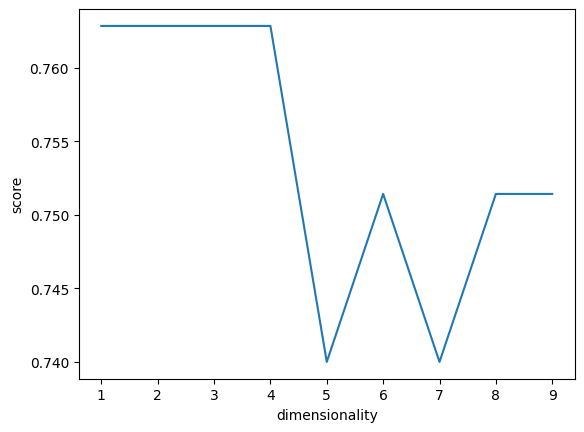

In [28]:
# plot the scores. x axis is 1-9, y axis is score.
import matplotlib.pyplot as plt
plt.plot(np.arange(1,10),scores)
plt.xlabel('dimensionality')
plt.ylabel('score')

initial score:  0.522857129573822
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.523', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '1.002', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.678', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '51.089', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.630', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '101.176', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.583', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '151.263', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test': '0.547', 'score_test': '0.769', 'train_data': 3450, 'max_epochs': 8000, '_epochs': '201.350', '_elapsed_time': 4, 'batch_size': 128}
{'ident': '', 'loss_test': '0.524', 'score_test': '0.769', 'train_data'

Text(0, 0.5, 'loss')

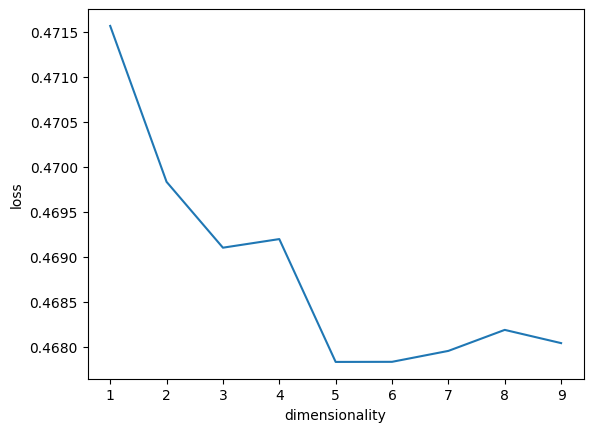

In [32]:
## Human triplets
human_responses_1 = pd.read_csv('../../data/reptile_tool/reptile_tool_human_triplets.csv')
human_responses_2 = pd.read_csv('../../data/reptile_tool/reptile_tool_human_triplets_2.csv')

human_responses = pd.concat((human_responses_1,human_responses_2),axis=0)
valid_puids = human_responses.groupby('puid')['puid_num_responses'].max()==200
valid_puids = valid_puids[valid_puids==True].index
responses_clean = human_responses[human_responses.puid.isin(valid_puids)].reset_index(drop=True)
# responses_clean.to_csv('../../data/reptile_tool/reptile_tool_human_triplets_clean.csv')
responses_clean
X_train=responses_clean[responses_clean.sampler=='Random']
X_test=responses_clean[responses_clean.sampler=='Validation']
X_train = X_train[['head','winner','loser']].to_numpy()
X_test = X_test[['head','winner','loser']].to_numpy()
n = len(np.unique(responses_clean.left_filename)) ## number of items
d=3 ### dimensionality we're embedding into
fit_online=True
scores = []
for d in range(1, 10):
    if fit_online:
        model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
        model.fit(X_train, X_test)
    scores.append(model.history_[-1]['loss_test'])
    
# plot the scores. x axis is 1-9, y axis is score.
import matplotlib.pyplot as plt
plt.plot(np.arange(1,10),scores)
plt.xlabel('dimensionality')
plt.ylabel('loss')

## gpt3 (002) semantic similarity

shape of the triplet dataframe:  (2809, 3)
initial score:  0.4626334607601166
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.511', 'train_data': 2247, 'max_epochs': 8000, '_epochs': '1.025', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.679', 'score_test': '0.733', 'train_data': 2247, 'max_epochs': 8000, '_epochs': '52.294', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.652', 'score_test': '0.722', 'train_data': 2247, 'max_epochs': 8000, '_epochs': '103.562', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.629', 'score_test': '0.717', 'train_data': 2247, 'max_epochs': 8000, '_epochs': '154.830', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.609', 'score_test': '0.714', 'train_data': 2247, 'max_epochs': 8000, '_epochs': '206.099', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test': 

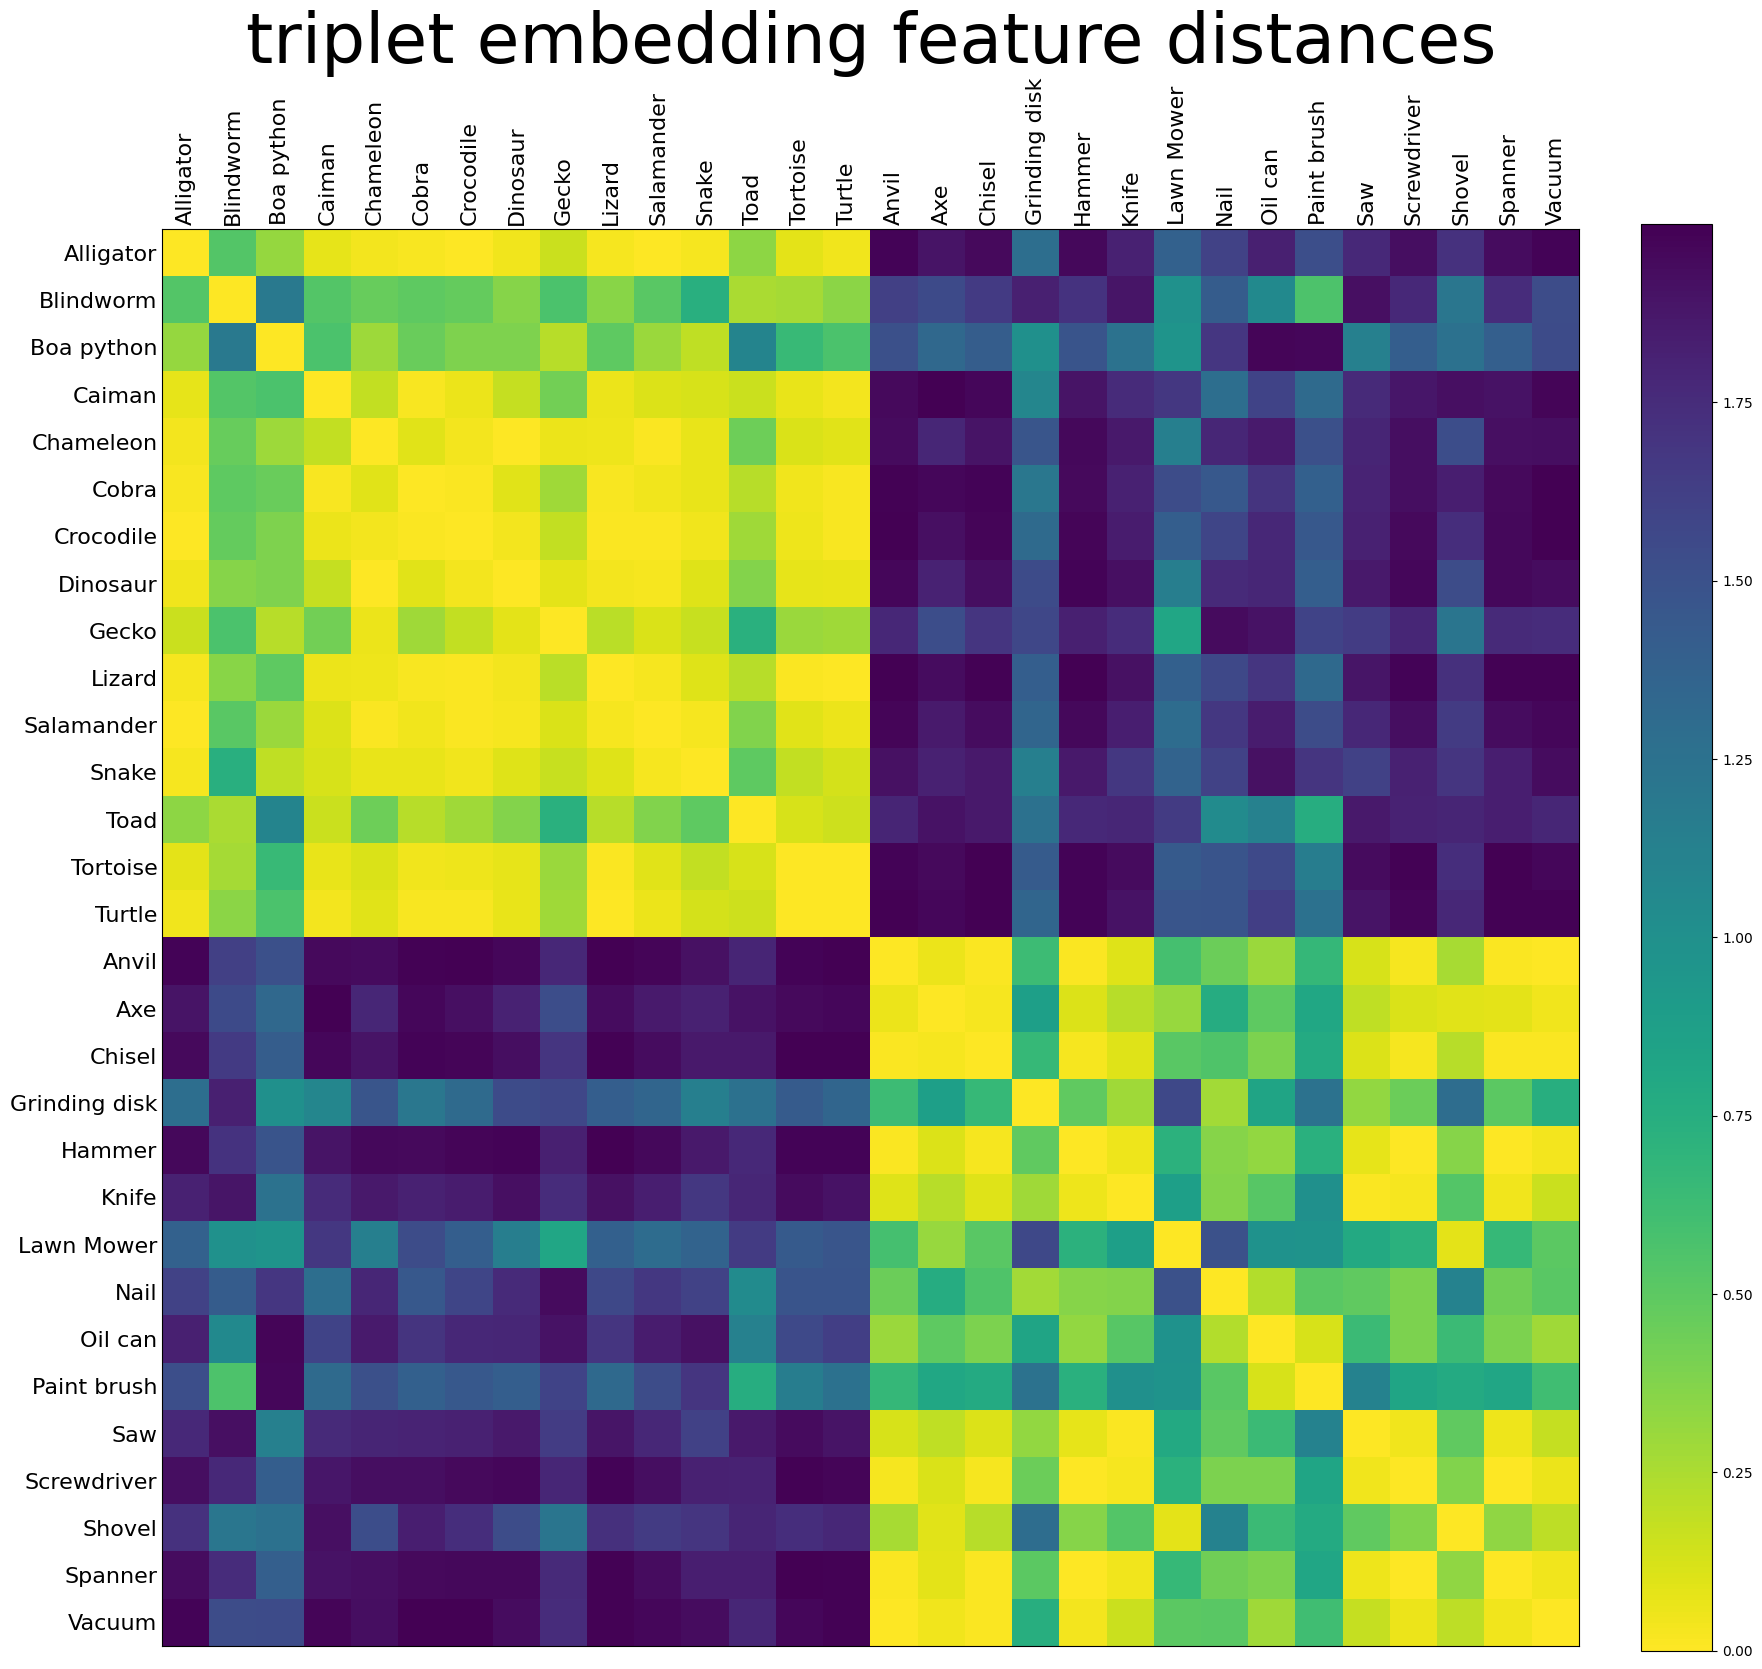

30

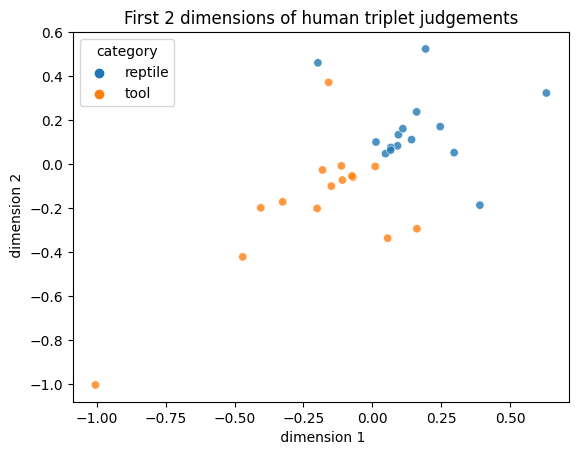

In [10]:

import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'text-davinci-002_semantic'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/text-davinici-002/davinci-002_triplet_rebuttal_semantic_prompt.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'answer']
heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    # if row['response'] != '': 
    #     try:
    #         row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
    #     except:
    #         continue
    # else:
    #     continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))


## flan xxl semantic similarity

shape of the triplet dataframe:  (2764, 3)
initial score:  0.4538878798484802
<class 'torch.optim.adadelta.Adadelta'> {'dwell': None, 'factor': 2.0, 'initial_batch_size': 128}
{'ident': '', 'loss_test': '0.693', 'score_test': '0.497', 'train_data': 2211, 'max_epochs': 8000, '_epochs': '1.042', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.684', 'score_test': '0.738', 'train_data': 2211, 'max_epochs': 8000, '_epochs': '53.145', '_elapsed_time': 0, 'batch_size': 128}
{'ident': '', 'loss_test': '0.652', 'score_test': '0.738', 'train_data': 2211, 'max_epochs': 8000, '_epochs': '105.248', '_elapsed_time': 1, 'batch_size': 128}
{'ident': '', 'loss_test': '0.625', 'score_test': '0.743', 'train_data': 2211, 'max_epochs': 8000, '_epochs': '157.351', '_elapsed_time': 2, 'batch_size': 128}
{'ident': '', 'loss_test': '0.605', 'score_test': '0.745', 'train_data': 2211, 'max_epochs': 8000, '_epochs': '209.455', '_elapsed_time': 3, 'batch_size': 128}
{'ident': '', 'loss_test': 

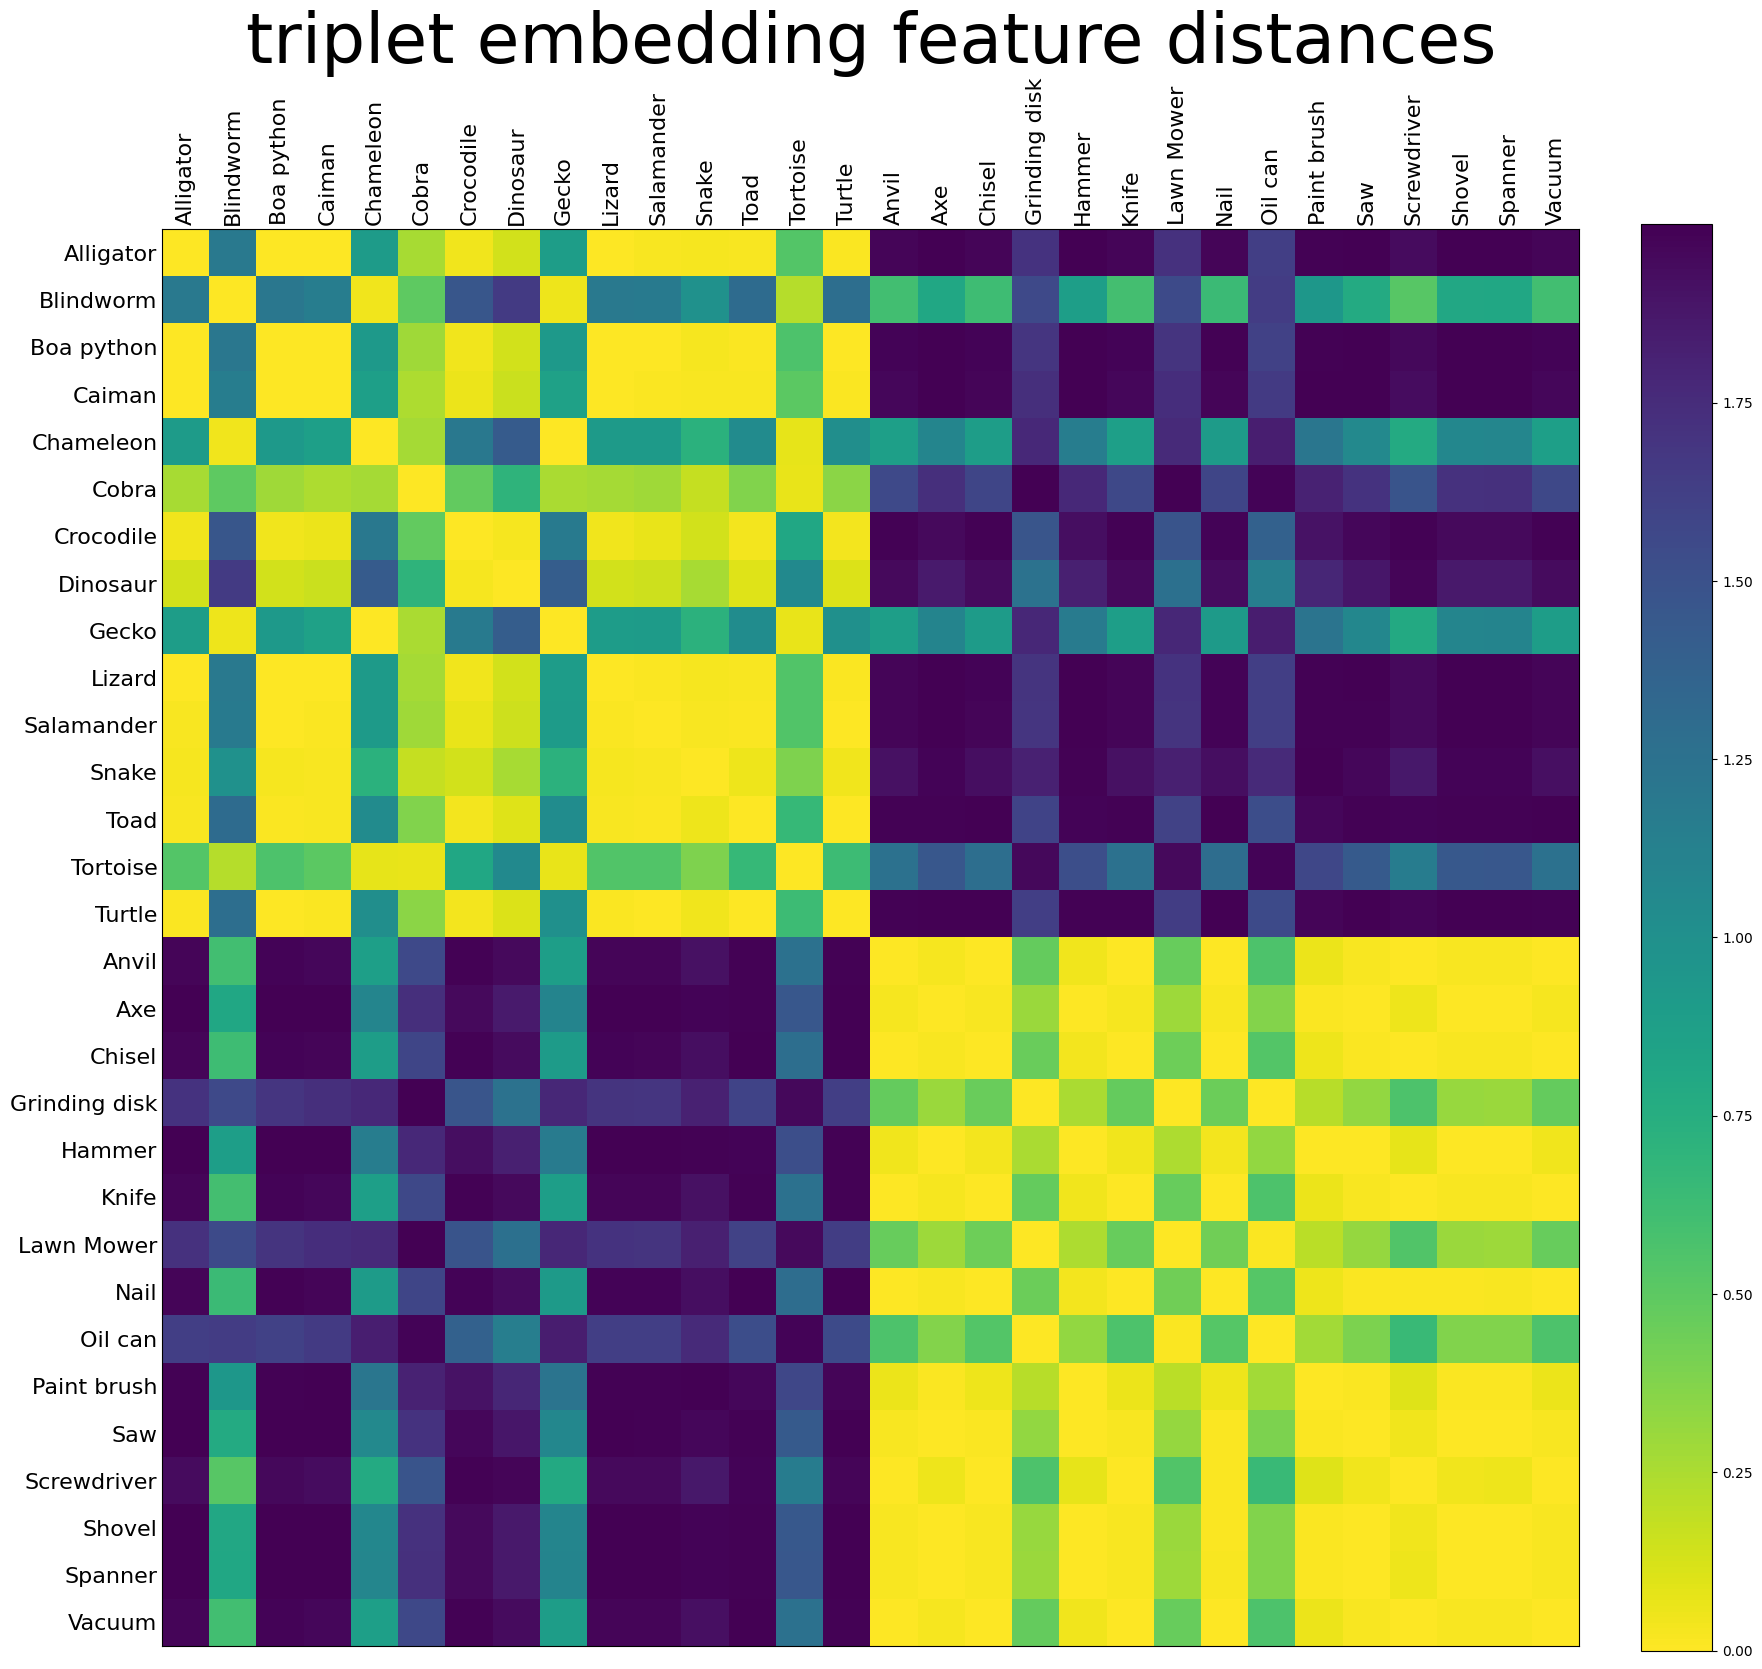

30

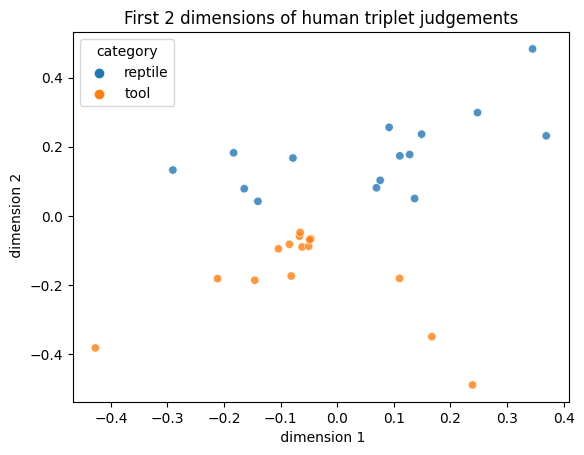

In [11]:

import pandas as pd
import math
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import os
import pickle
from salmon.triplets.offline import OfflineEmbedding
model_fname = 'flan-xxl_semantic'
# Set the columns of the df as 'prompt', 'response', 'answer'
flan_xxl_cot = pd.read_csv('../../emnlp/data/triplets/new_data/flan-xxl/flan-xxl_triplet_rebuttal_semantic_prompt.csv', header=None)
flan_xxl_cot.columns = ['prompt', 'answer']
heads = []
winners = []
losers = []

for i, row in flan_xxl_cot.iterrows():
    # if row['response'] != '': 
    #     try:
    #         row['answer'] = row['response'].split('answer is ')[-1].split('.')[0]
    #     except:
    #         continue
    # else:
    #     continue
    # if 'Boa python' 'Grinding disk', 'Lawn Mower', 'Oil can', 'Paint brush'
    left = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[0]
    right = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[0]
    anchor = row['prompt'].split('Answer using only one word - ')[1].split(' or ')[1].split(" and not ")[1].split('.')[0]
    if left.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(left)
        losers.append(right)
    elif right.lower() in row['answer'].lower():
        heads.append(anchor)
        winners.append(right)
        losers.append(left)
    else:
        continue
    
trips_df = pd.DataFrame({'head':heads,'winner':winners,'loser':losers})
print('shape of the triplet dataframe: ', trips_df.shape)




## generate a dictionary that maps the concepts to numbers like Salmon does

concept_to_int_dict = dict(zip(np.unique(trips_df),np.arange(len(np.unique(trips_df)))))

## generate a reverse dictionary
int_to_concept_dict = dict(zip(np.arange(len(np.unique(trips_df))),np.unique(trips_df)))

##change names to numbers
trips_df = trips_df.applymap(lambda x : concept_to_int_dict[x])

##create concept to category dict
maps = { 
    ('Alligator','Boa python', 'Blindworm','Caiman', 'Chameleon', 'Cobra', 'Crocodile', 'Dinosaur', 'Gecko',\
    'Lizard','Salamander','Snake', 'Toad', 'Tortoise', 'Turtle'): 'reptile', 
    ('Anvil', 'Axe','Chisel','Grinding disk', 'Hammer', 'Knife', 'Lawn Mower','Nail', 'Oil can', 'Paint brush',\
    'Saw', 'Screwdriver', 'Shovel','Spanner','Vacuum') : 'tool',
}

concept_to_category = {}
for k, v in maps.items():
    for key in k:
        concept_to_category[key] = v

###fitting 3d embeddings

n = len(np.unique(trips_df)) ## number of items
d=3 ### dimensionality we're embedding into
X_train, X_test = train_test_split(trips_df.to_numpy(), random_state=42, test_size=0.2)
fit_online=True
if fit_online:
    model = OfflineEmbedding(n=n, d=d, max_epochs=8000,verbose=50)
    model.fit(X_train, X_test)
    with open(f'../../results/reptile_tool/reptile_tool_{model_fname}_embeds.pkl', 'wb') as f:
        pickle.dump(model, f)
    


embeddings_df_gpt = pd.DataFrame(np.hstack((np.array(list(concept_to_int_dict.keys())).reshape(n,1),model.embedding_)))
embeddings_df_gpt.columns = ['concept','embed_1','embed_2','embed_3']

embeddings_df_gpt['category'] = embeddings_df_gpt.apply(lambda x: concept_to_category[x['concept']],axis=1)
embeddings_df_gpt = embeddings_df_gpt.sort_values(by = ['category','concept']).reset_index(drop=True)
embeddings_df_gpt[['embed_1','embed_2','embed_3']]= embeddings_df_gpt[['embed_1','embed_2','embed_3']].astype('float64')

embeddings_df_gpt.to_csv(f'../../emnlp/embeddings_data/{model_fname}.csv')
import scipy
import matplotlib.pyplot as plt
pdmat = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(embeddings_df_gpt[['embed_1','embed_2','embed_3']], metric='cosine'))

plt.figure(figsize=(20,20))
plt.matshow(pdmat,fignum=1,cmap=plt.get_cmap('viridis_r'))
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.xticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16, rotation=90)
plt.yticks(range(embeddings_df_gpt.shape[0]),embeddings_df_gpt.concept,fontsize=16)
cb = plt.colorbar(fraction=0.046, pad=0.04)
plt.title('triplet embedding feature distances', fontsize=50)
#plt.savefig('part_dist.pdf', bbox_inches='tight')
plt.show()
import seaborn as sns
sns.scatterplot(
            x="embed_1", y="embed_2",
            hue="category",
            #palette=sns.color_palette(pca_pal),
            data=embeddings_df_gpt,
            legend="full",
            alpha=0.8
        ).set_title(f'First 2 dimensions of human triplet judgements')
plt.xlabel(' dimension 1')
plt.ylabel(' dimension 2')
len(set(heads))
